## Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn_image as isns
import seaborn as sns
import scipy.signal as signal
from scipy import stats

import statsmodels.stats.multitest as smm

from sonar import sonar, utils, son_stats, plotting
import math

from distinctipy import distinctipy

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec

# Upload sample, define labels

In [5]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
'Endothelial'
]

In [6]:
relevant_cluster_labels =  [
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan'
]

In [3]:
# osmfish_ref = ['Astrocyte Gfap', 'Astrocyte Mfge8', 'C. Plexus', 'Endothelial', 
#                'Endothelial 1', 'Ependymal', 'Hippocampus', 'Inhibitory CP', 
#                'Inhibitory Cnr1', 'Inhibitory Crhbp', 'Inhibitory IC', 'Inhibitory Kcnip2', 
#                'Inhibitory Pthlh', 'Inhibitory Vip', 'Microglia', 'Oligodendrocyte COP', 
#                'Oligodendrocyte MF', 'Oligodendrocyte Mature', 'Oligodendrocyte NF', 'Oligodendrocyte Precursor cells', 
#                'Pericytes', 'Perivascular Macrophages', 'Pyramidal Cpne5', 'Pyramidal Kcnip2', 
#                'Pyramidal L2-3', 'Pyramidal L2-3 L5', 'Pyramidal L3-4', 'Pyramidal L5', 
#                'Pyramidal L6', 'Vascular Smooth Muscle', 'pyramidal L4']

# relevant_cluster_labels = osmfish_ref

In [7]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'


In [8]:
# sample_list = []
# for sample in range(1,5):
#     n_sample = sample

#     tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]
#     # Islet stack
#     rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
#     # rescaled_splitted = np.split(rescaled, 16)
#     # islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])
#     sample_list.append(rescaled)


tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(1)]
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()

In [9]:
rescaled[1:-2].shape

(13, 1788, 2343)

In [5]:
# tissue_matrix_brain_ = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/osmFISH/data/published_cell_matrix.npz')['raw']


In [62]:
# tissue_matrix_brain_.shape

(33, 1640, 3500)

In [6]:
# tissue_matrix_brain = np.delete(tissue_matrix_brain_, [6,32], axis=0) # removing empty entities
# tissue_matrix_brain.shape

# rescaled = tissue_matrix_brain

In [68]:
# tissue_matrix_brain_.files

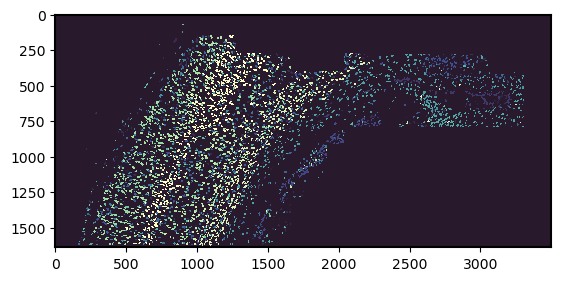

In [8]:
# plt.imshow(tissue_matrix_brain.argmax(0))

Text(0.5, 1.0, 'Sample4, scaling = 0.3')

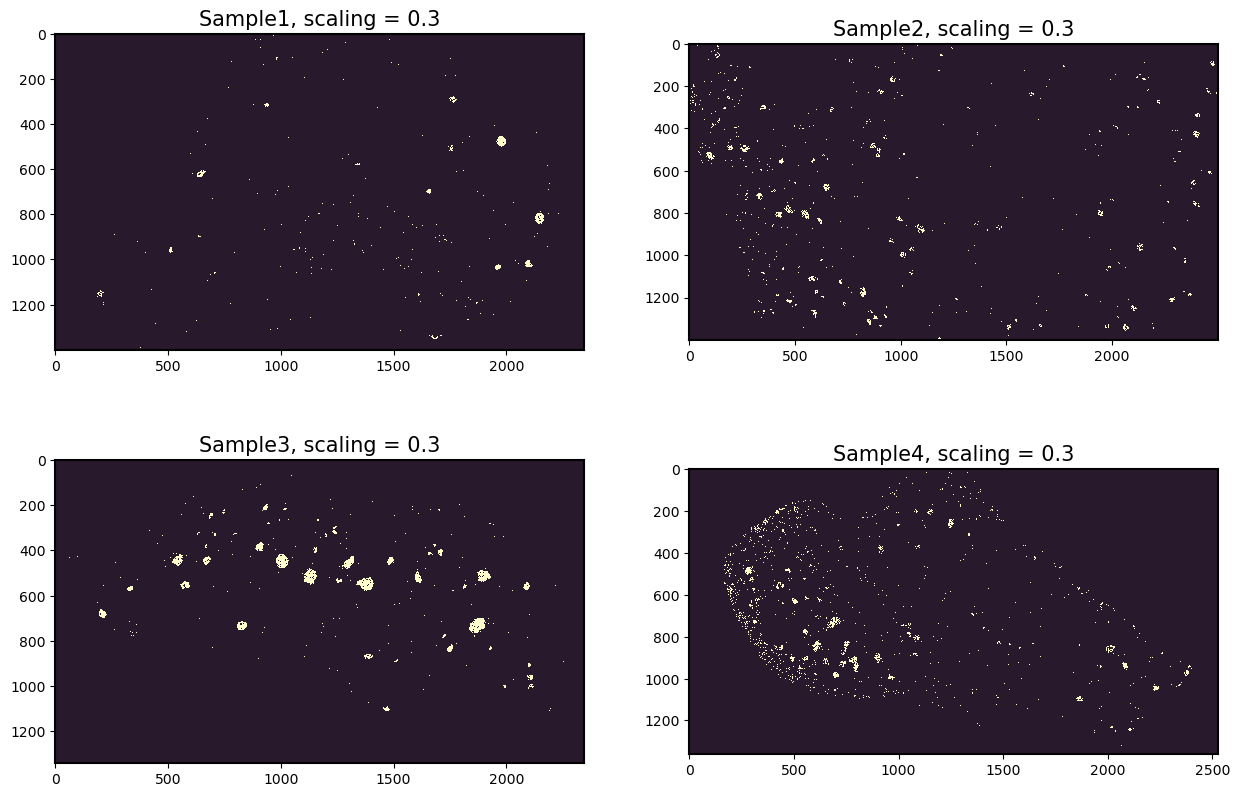

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(sample_list[0][0][200:1600,:])
plt.title("Sample1, scaling = 0.3")

plt.subplot(2,2,2)
plt.imshow(sample_list[1][0][350:1750,500:3000])
plt.title("Sample2, scaling = 0.3")

plt.subplot(2,2,3)
plt.imshow(sample_list[2][0].T)
plt.title("Sample3, scaling = 0.3")

plt.subplot(2,2,4)
plt.imshow(sample_list[3][0][200:,:])
plt.title("Sample4, scaling = 0.3")

In [16]:
# rescaled = sample_list[0] # selecting sample

# Sonar run

In [10]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

In [11]:
son = sonar.Sonar(labels = relevant_cluster_labels, max_radius=rad_,linear_radius_steps=lin, edge_correction=True, circumference_normalization=True)

In [12]:
cooc_template_ = son.co_occurrence_from_tensor(rescaled[1:-2],interpolate="linear", area_normalization = True) 

In [13]:
son.co_occurrence.shape

(13, 13, 37)

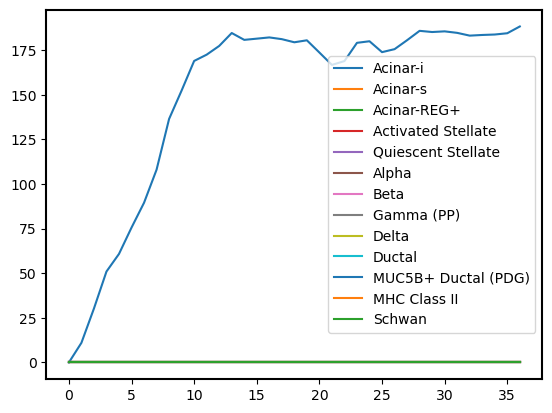

In [14]:
for i in range(son.co_occurrence.shape[0]):
    plt.plot(son.co_occurrence[5,i], label=relevant_cluster_labels[i])
# plt.ylim(-0.0001,0.001)
plt.legend()

In [41]:
def _interpolate(x,y,step, method='linear'):

    from scipy import interpolate 
    """_interpolat generates linear interpolation from the x,y to create mutual distance curves in um units
    :param x: distances with available values
    :type x: np.array
    :param y: values at x
    :type y: np array
    :param step: step size of x,y
    :type step: float
    :param method: interpolation method out of ['linear','BSpline'], defaults to 'linear'
    """

    # return lambda x_ :  interpolate.BSpline(*interpolate.splrep(x,y,s=0,k=5), extrapolate=False)

    if method=='linear':
        return np.apply_along_axis(lambda x_ :  interpolate.interp1d(x,x_,kind='linear',fill_value='extrapolate')(np.arange(0,x.max()*step)),2,y)
    elif method=='BSpline':
        return np.apply_along_axis(lambda x_ :  interpolate.BSpline(*interpolate.splrep(x,x_,s=1,k=2), extrapolate=False)(np.arange(0,x.max()*step)),2,y)


In [42]:
# final normalization
n, _, m = cooc_template_.shape
normalized_coocur = np.zeros_like(cooc_template_)

In [51]:
radii = rad_
co_occurrences = cooc_template_

In [55]:
# co_occurrences = _interpolate(radii, co_occurrences, 1, method='linear')

co_occurrences = co_occurrences/(co_occurrences[:,:,0].diagonal()[:,None,None])

/tmp/ipykernel_397058/4203652512.py:3: RuntimeWarning: divide by zero encountered in divide
  co_occurrences = co_occurrences/(co_occurrences[:,:,0].diagonal()[:,None,None])
/tmp/ipykernel_397058/4203652512.py:3: RuntimeWarning: invalid value encountered in divide
  co_occurrences = co_occurrences/(co_occurrences[:,:,0].diagonal()[:,None,None])


In [34]:
cooc_template_[:,:,0].diagonal()

array([7.64270000e+004, 2.82450523e+084, 6.35535225e+112, 4.10498527e+179,
       6.36517606e+117, 1.25715944e+035, 6.22332723e-056, 1.98248791e-099,
       2.49591890e+208, 8.76837046e+223, 6.90700354e-310, 0.00000000e+000,
       0.00000000e+000])

In [13]:
cooc_template_[:,:,0].diagonal()

array([7.64270000e+004, 7.74860419e-304, 4.94065646e-324, 7.74860419e-304,
       7.74860419e-304, 7.74860419e-304, 7.74860419e-304, 7.74860419e-304,
       7.74860419e-304, 7.74860419e-304, 7.74860419e-304, 7.74860419e-304,
       7.74860419e-304])

In [59]:
co_occurrences

array([[[ 1.00000000e+00,  5.49525609e-01,  2.96118866e-01, ...,
          9.10550072e-02,  9.12306113e-02,  9.12214881e-02],
        [ 2.21299088e-08,  4.10685401e-01,  6.82488120e-01, ...,
          8.08712481e-01,  8.10390655e-01,  8.11189926e-01],
        [ 7.25025145e-11,  1.43936948e-03,  2.90586545e-03, ...,
          4.90933025e-03,  4.85125713e-03,  4.87893846e-03],
        ...,
        [-6.46913763e-11,  7.07017604e-05,  1.71021256e-04, ...,
          9.14360179e-03,  8.97688454e-03,  8.85152477e-03],
        [ 1.06981639e-11,  8.44877368e-05,  1.72079261e-04, ...,
          1.11354551e-03,  1.11718166e-03,  1.12507490e-03],
        [-3.16399780e-12,  1.21914782e-05,  3.99520465e-05, ...,
          2.67562178e-04,  2.69241699e-04,  2.73223031e-04]],

       [[            inf,             inf,             inf, ...,
                     inf,             inf,             inf],
        [            nan,             inf,             inf, ...,
                     nan,             

In [23]:
stats_result = son_stats.significance_test(cooc_template_)

In [39]:
stats_result[0].shape

(13, 13, 37)

<Axes: >

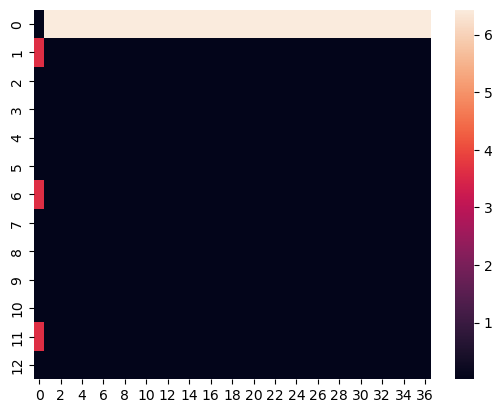

In [40]:
sns.heatmap(-np.log10(stats_result[0][5, :, :]))

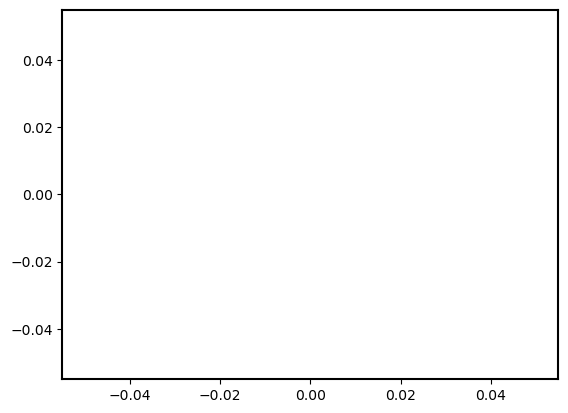

In [58]:
for target_cell_type in range(13):

    plt.plot(co_occurrences[5,target_cell_type]) #, color=colors[target_cell_type % len(colors)])
    # plt.title("cross-corellation of ... cells, interpolate='linear")
    # plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1))

# plt.ylim(-0.1,3000)
plt.show()

# Normalisation

In [76]:
# for i in range(tissue_matrix_brain.shape[0]):
#     print(np.sum(tissue_matrix_brain[i,:,:]))

In [77]:
len(relevant_cluster_labels)

31

In [9]:
def normalise_co_occurrence(tensor, original_img, cell_type_labels):
    """
    Normalize co-occurrence results based on cell type proportions.

    Args:
        tensor (numpy.ndarray): Co-occurrence tensor to normalize.
        original_img (numpy.ndarray): Original image data.
        cell_type_labels (list): List of cell type labels.

    Returns:
        normalized_coocur (numpy.ndarray): Normalized co-occurrence tensor.
        pixel_counts_dict (dict): Dictionary containing pixel counts and proportions for each cell type.
    """
    
    # Remove bg
    # original_img = original_img[:-1] # original_img[-1] = background, which we didn't calculate in sonar ## we need a statement for where is a background

    # Calculating total pixels
    pixel_counts_list = []
    for i in range(len(cell_type_labels)): 
        pixels_per_layer = np.sum(original_img[i]) 
        pixel_counts_list.append(pixels_per_layer)


    # Check for empty layers, filtering them out
    pixel_counts_dict = dict(zip(cell_type_labels, pixel_counts_list))

    for cell_type in pixel_counts_dict.keys():
        if pixel_counts_dict[cell_type] == 0:
            print(f"WARNING: class label '{cell_type}' has 0 counts in the input data")

    empty_cell_type_map = [index for index, value in enumerate(pixel_counts_dict.values()) if value == 0]
    cooc_template_no_empty =np.delete(tensor, empty_cell_type_map, axis=0)
    cooc_template_no_empty =np.delete(cooc_template_no_empty, empty_cell_type_map, axis=1) #same needed for labels, remove irrelevant ones
    tensor = cooc_template_no_empty

    iteration_through_dict_keys = list(pixel_counts_dict.keys()).copy()
    for cell_type in iteration_through_dict_keys: # repetition, might need optimization
        if pixel_counts_dict[cell_type] == 0:
            del pixel_counts_dict[cell_type]



    
    # Calculating cell-type proportions
    total_n = sum(list(pixel_counts_dict.values()))
    for cell_type in list(pixel_counts_dict.keys()):
        ratio = (pixel_counts_dict[cell_type])/total_n
        ratio = round(ratio,5)
        pixel_counts_dict[cell_type]=[pixel_counts_dict[cell_type], ratio]

    
    # Normalisation
    n, _, m = tensor.shape
    normalized_coocur = np.zeros_like(tensor)

    pixel_counts = list(pixel_counts_dict.values())
    cell_t_proportions = list(pixel_counts_dict.values())
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_coocur[i, j, k] = tensor[i, j, k] / (pixel_counts[j][0]*cell_t_proportions[i][1])

    metadata = pd.DataFrame(pixel_counts_dict, index=['total_px_count', 'proportion_in_sample']).T # to rewrite function to earlier application of df

    # print(pixel_counts_dict)
    # print(metadata)

    return normalized_coocur, metadata # It is nice to have a container for the metadata for the rurther steps. But I don't know if it is better to keep this data in dict, or in pd.df. Probabply, df will be better

In [10]:
normalized_coocur, metadata = normalise_co_occurrence(tensor=cooc_template_, original_img = rescaled, cell_type_labels = relevant_cluster_labels)


# Significance test

In [11]:
def significance_test(normalized_coocur=normalized_coocur):
    """
    Perform significance tests on normalized co-occurrence data.

    This function conducts significance tests to determine if the normalized co-occurrence values
    are significantly different from the overall mean. It uses t-tests for each cell type pair and distance.

    Args:
        normalized_coocur (numpy.ndarray): 3D array of normalized co-occurrence values.
        metadata: Additional metadata (not used in this function).

    Returns:
        less_greater (list of numpy.ndarray): List containing 3D arrays of corrected p-values for "less" and "greater" alternatives.

    Note:
        The p-values are corrected for multiple hypothesis testing using the Benjamini-Hochberg procedure (method='fdr_bh').
        This correction helps control the False Discovery Rate (FDR) when conducting numerous tests.
        Corrected p-values are provided in the returned 3D arrays for further interpretation and analysis.
    """
    less_greater = [] # maybe should be changed to numpy.ndarray, but I find a list more convenient in this case

    # performing 1-sided ttest with two alternative options: lees and greater, to see both "ups" and "donws"
    alternatives = ["less", "greater"]
    for one_side in alternatives:

        significance_test = np.zeros((normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2]))
        for pivot_cell_type in range(normalized_coocur.shape[0]):
            for target_cell_type in range(normalized_coocur.shape[1]):
                for distance in range(normalized_coocur.shape[2]):

                    value_to_test = normalized_coocur[pivot_cell_type, target_cell_type, distance]
                    t_statistic, p_value = stats.ttest_1samp(normalized_coocur[pivot_cell_type,:,distance], value_to_test, alternative=one_side)
                    significance_test[pivot_cell_type, target_cell_type, distance] = p_value

    # correction for multiple hypothesis testing
        significance_test_flatten = significance_test.flatten()
        corrected_p_values = smm.multipletests(significance_test_flatten, method='fdr_bh')[1] 
        corrected_p_values3D = corrected_p_values.reshape(normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2])
        
        less_greater.append(corrected_p_values3D)

    return less_greater


In [12]:
significant_enrichment = significance_test(normalized_coocur=normalized_coocur)

In [13]:
significant_enrichment[0].shape

(31, 31, 1000)

# Plotting

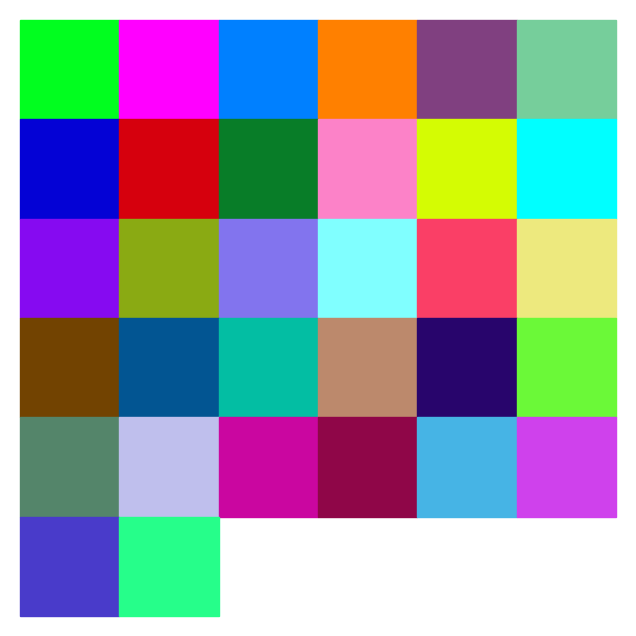

In [25]:
from distinctipy import distinctipy
import random
random.seed(13)

# number of colours to generate
# N = len(indices_above_threshold)
N = 32

# generate N visually distinct colours
colors = distinctipy.get_colors(N)

# display the colours
distinctipy.color_swatch(colors)

In [83]:
metadata

,total_px_count,proportion_in_sample
Astrocyte Gfap,10203.0,0.01737
Astrocyte Mfge8,13694.0,0.02332
C. Plexus,5452.0,0.00928
Endothelial,28938.0,0.04927
Endothelial 1,8964.0,0.01526
Ependymal,14731.0,0.02508
Hippocampus,18463.0,0.03144
Inhibitory CP,25119.0,0.04277
Inhibitory Cnr1,6756.0,0.01150
Inhibitory Crhbp,20261.0,0.03450


In [33]:
ct = list(metadata[metadata['proportion_in_sample']>0.0005].index)



In [26]:
thresholded_cell_types = list(metadata.loc[metadata['proportion_in_sample']>0.0005].index)
thresholded_cell_types

NameError: name 'metadata' is not defined

In [162]:
def plot_significant_enrichments(normalized_coocur=normalized_coocur,
metadata=metadata,
seed_ = 13,
threshold = 0.0005,
significant_enrichment = significant_enrichment,
filename = "mouse_brain_2",
scaling = 1,
max_dist = 1000):

    metadata["order_of_layers"] = list(range(len(metadata)))
        # metadata_reset = metadata.reset_index()
        # metadata_reset.rename(columns={'index': 'cell_type'}, inplace=True)
        # metadata_reset.set_index('order_of_layers', inplace=True)

    all_cell_types = list(metadata.index)
    cell_types_above_threshold = list(metadata.loc[metadata['pixel_proportions']>0.0005, 'order_of_layers'])
    thresholded_cell_types = list(metadata.loc[metadata['pixel_proportions']>0.0005].index)


        # colors
        
    random.seed(seed_)
        # number of colours to generate
    N = len(cell_types_above_threshold)
        # generate N visually distinct colours
    colors = distinctipy.get_colors(N)


    # filenames
    from datetime import datetime
    current_datetime = datetime.now()
        # Format the date and time
    formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
        # Create a PDF file
    pdf_filename = filename + formatted_datetime + ".pdf"
    pdf_pages = PdfPages(pdf_filename)



    for figure in cell_types_above_threshold:

            # Initiating a figure
        # fig, axes = plt.subplots(3,1, figsize=(10,len(cell_types_above_threshold)//2), sharex=True)
        fig = plt.figure(figsize=(14, 12))  # Overall figure size
        from matplotlib import gridspec
        gs = gridspec.GridSpec(3, 1, height_ratios=[1,3,3])

        pivot_cell_type = figure 

            # Sonar cross-correlation curves
        ax_curves = plt.subplot(gs[0])
        for target_cell_type in cell_types_above_threshold:

                # y_maximum = normalized_coocur[pivot_cell_type,:,10:].mean() + normalized_coocur[pivot_cell_type,:,10:].std()*2.5

            ax_curves.plot(normalized_coocur[pivot_cell_type,target_cell_type], label = all_cell_types[target_cell_type], color=colors[target_cell_type % len(colors)])
            ax_curves.legend(loc="upper right", bbox_to_anchor=(-0.2, 1))
            ax_curves.set_ylim(-0.5,5)
        ax_curves.set_ylabel('Relative enrichment', labelpad=15)


            # Define axes for each subplot
        heatmaps = [1, 2]

            # Define alternative types
        alternatives = significant_enrichment
        alt_name = ["less", "greater"]

        for heatmap_loc, alternative, a_name in zip(heatmaps, alternatives, alt_name):
            ax = plt.subplot(gs[heatmap_loc], sharex=ax_curves)
                # Significance heatmap of one-sided t-test
            sns.heatmap(-np.log10(alternative[pivot_cell_type, cell_types_above_threshold, :]), cmap="rocket", yticklabels=thresholded_cell_types, vmin=1.6, vmax=6, ax=ax, cbar=False)
                # Add a text annotation on the right side of the plot

            # ax.annotate(f"alternative={a_name}", xy=(0, 0), xytext=(620, 6), color="black",
            #                 rotation=-90, ha='right', va='center', fontsize=14)
                # Adjust the frame of the heatmap
            for spine in ['top', 'right', 'bottom', 'left']:
                ax.spines[spine].set_visible(True)
                ax.spines[spine].set_linewidth(1)

            
            # Customize x-axis ticks
        xlox = np.linspace(0,max_dist,max_dist//10)  #use the shape of provided tensor!
        xtix = [str(int(i)) for i in xlox*scaling] # *3 is getting back from scaling the sample which was used for avoiding memory issues while calculating sonar curves
        plt.xticks(xlox,xtix)   
    # Rotate x-tick labels on the bottom subplot
        ax_curves.set_xticklabels(ax_curves.get_xticklabels(), rotation=90, ha='right')

        plt.tight_layout()

            # Create a color bar
        cbar_ax = fig.add_axes([0.91, 0.05, 0.02, 0.6])  # Adjust the values as needed
        cbar = plt.colorbar(ax.collections[0], cax=cbar_ax)
        cbar.set_label('-Log10 Significance', rotation=90, labelpad=10)
        cbar.outline.set_linewidth(1)

            # Adjust the linewidth of legend lines
        legend_lines = ax_curves.get_legend().get_lines()
        for line in legend_lines:
            line.set_linewidth(5.0)

        plt.xlabel('Distance, um/px', labelpad=40) # Add x-axis label to the entire figure
        plt.suptitle(f"Cross-correlation of {all_cell_types[figure]}", fontsize=15, y=1.01)

            # Save the current figure to the PDF file
        pdf_pages.savefig()

            # Close the current figure
        plt.close()
            
    # # Close the PDF file
    pdf_pages.close()



In [163]:
plot_significant_enrichments(normalized_coocur=normalized_coocur,
metadata=metadata,
seed_ = 13,
threshold = 0.0005,
significant_enrichment = significant_enrichment,
filename = "mouse_brain_2",
scaling = 1,
max_dist = 1000)

/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight 

In [28]:
metadata = son.meta

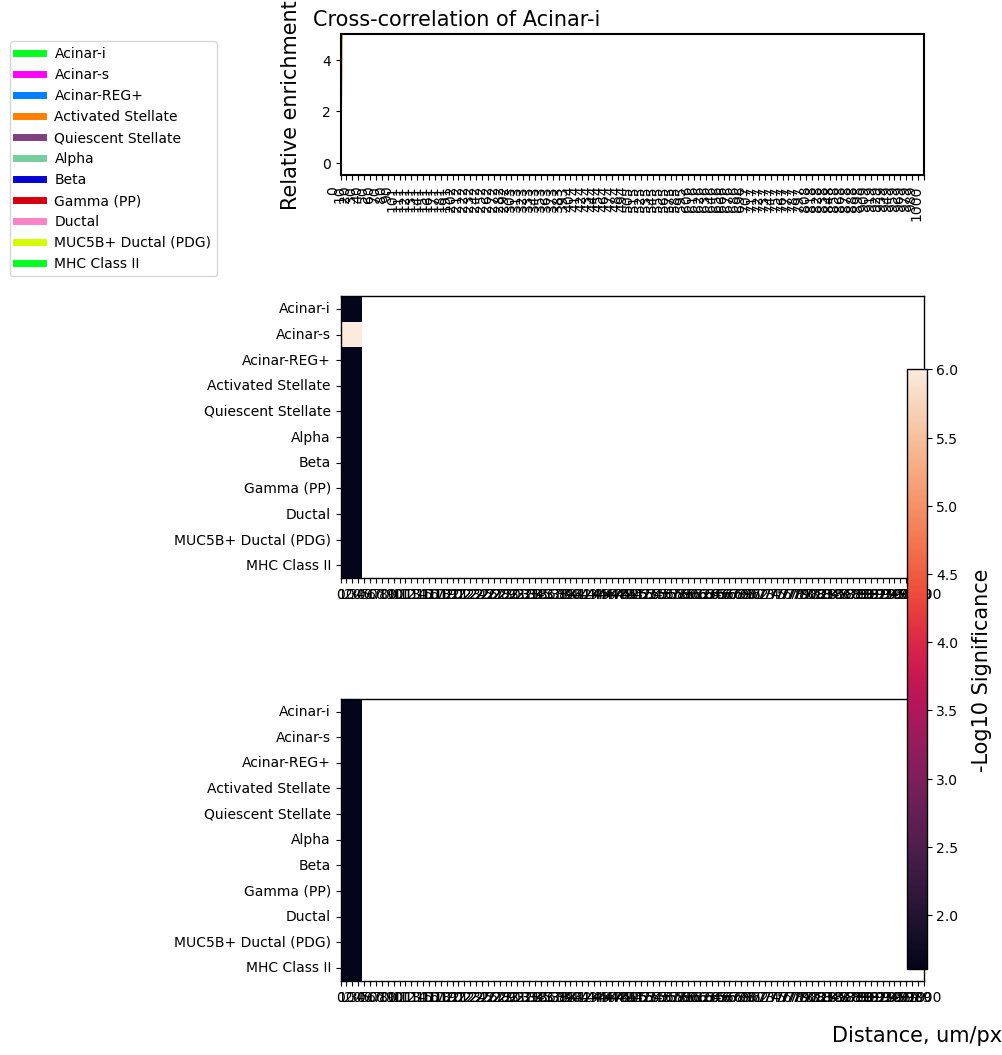

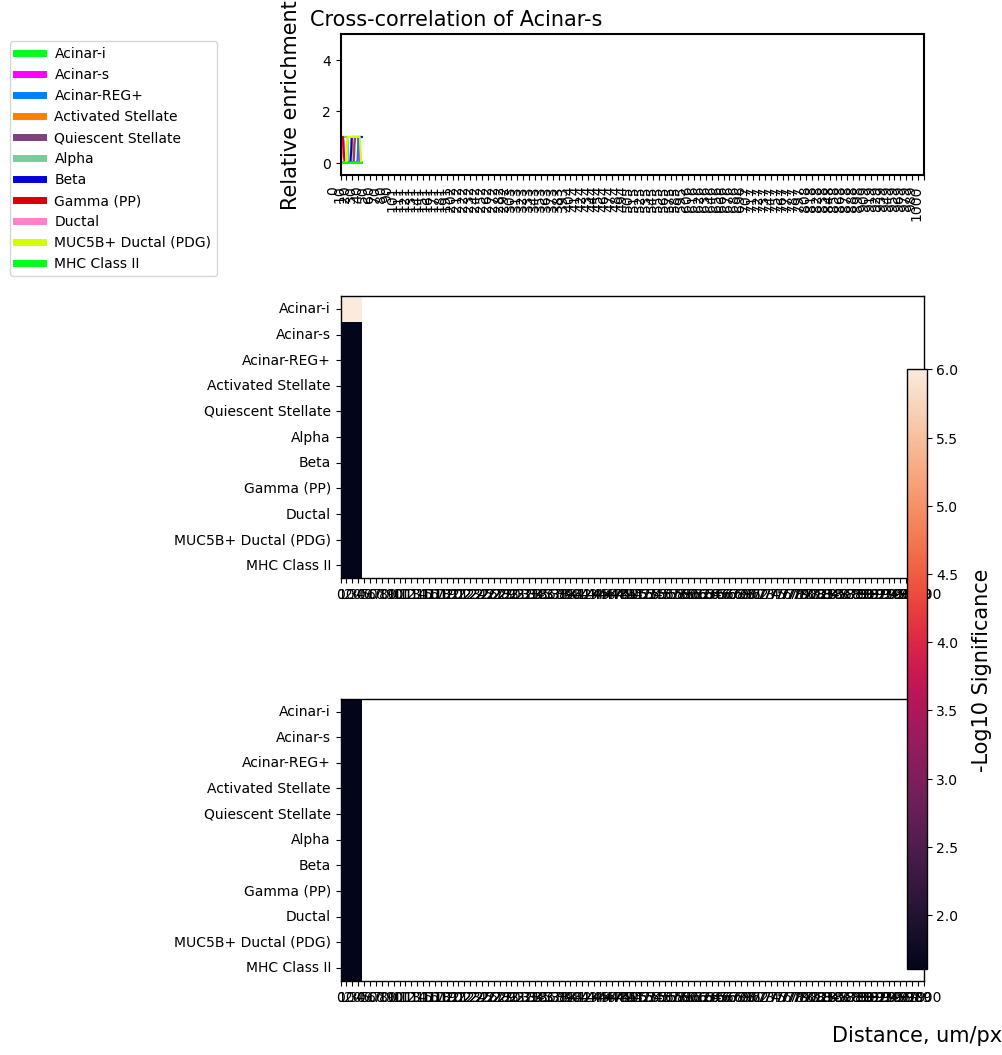

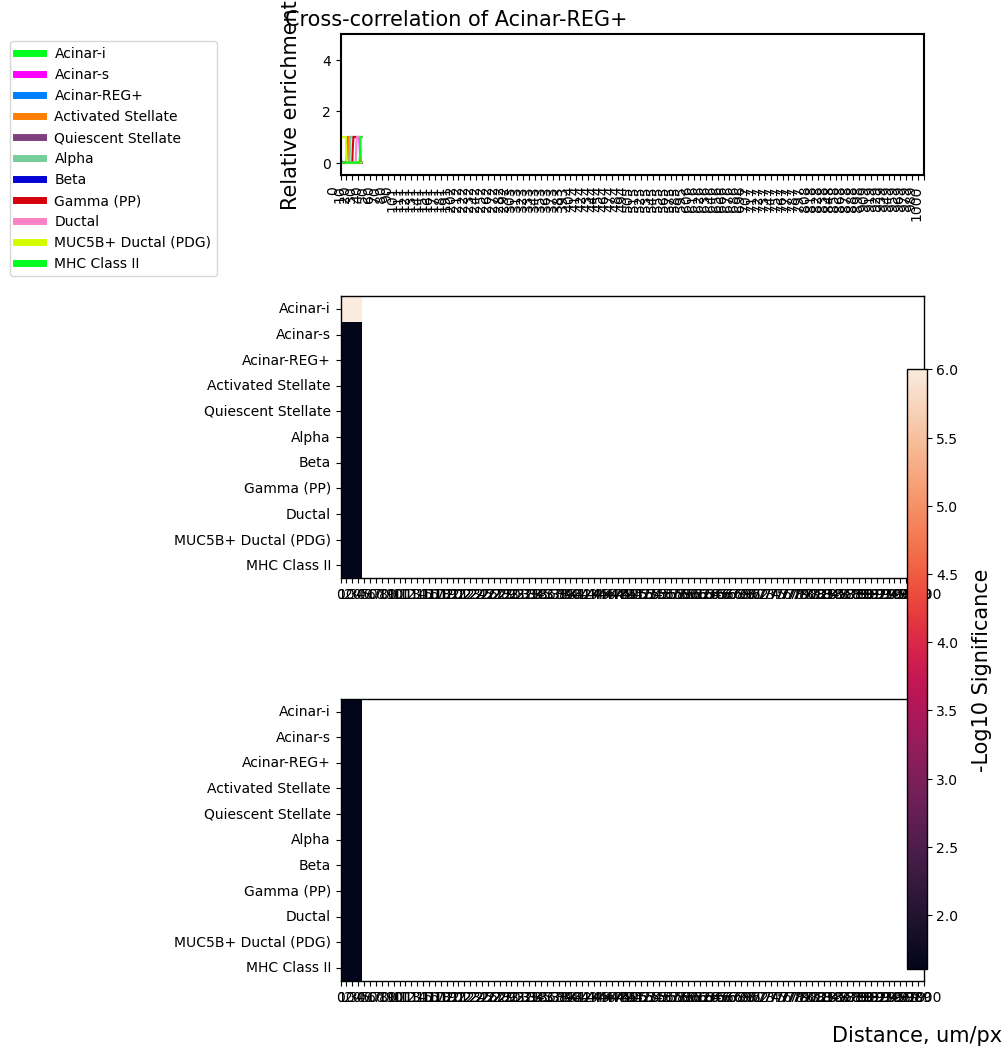

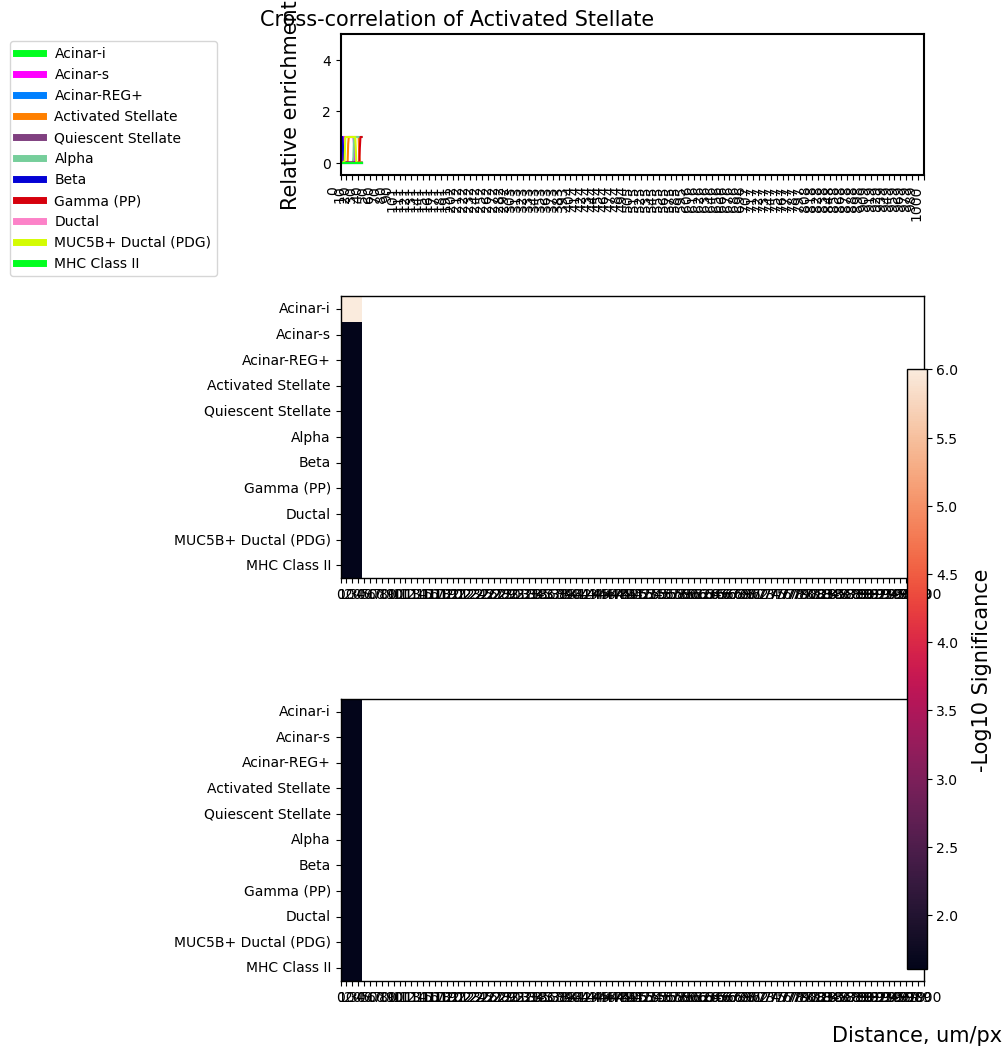

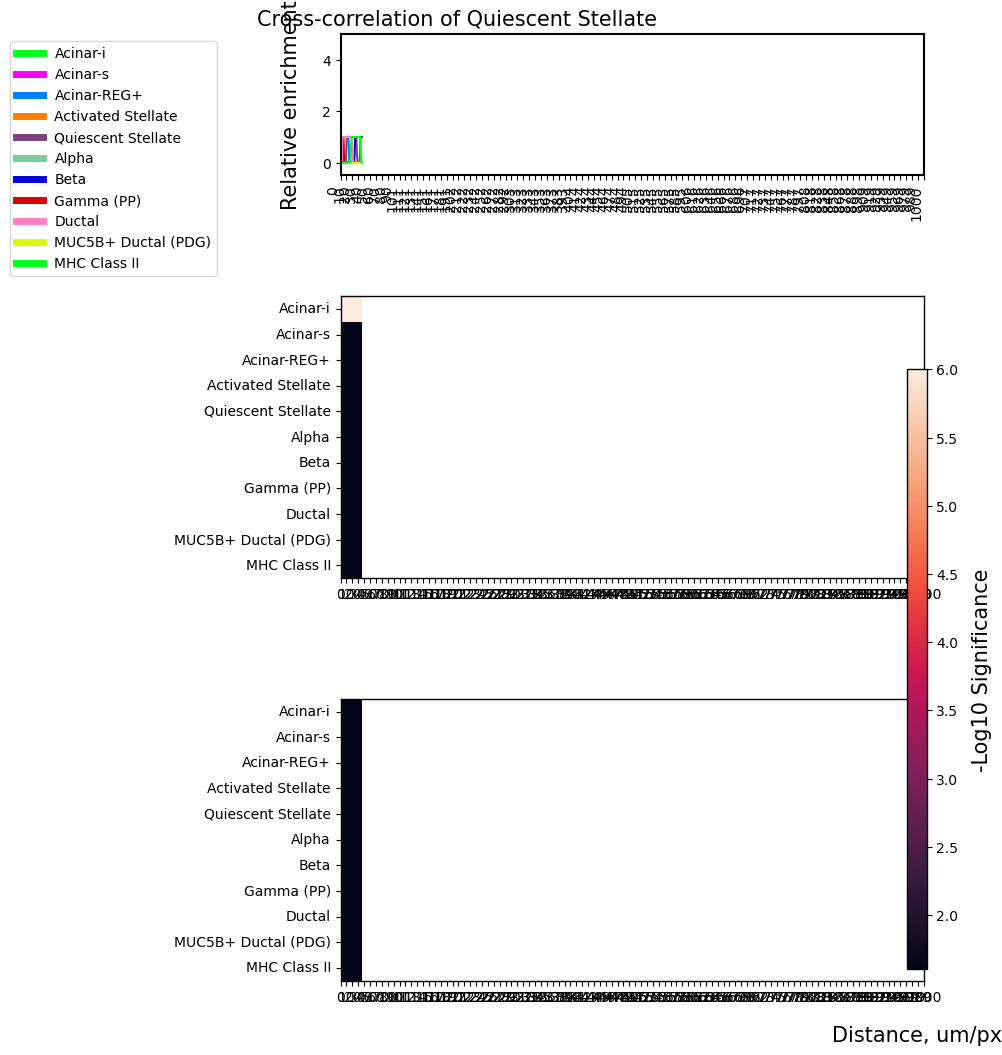

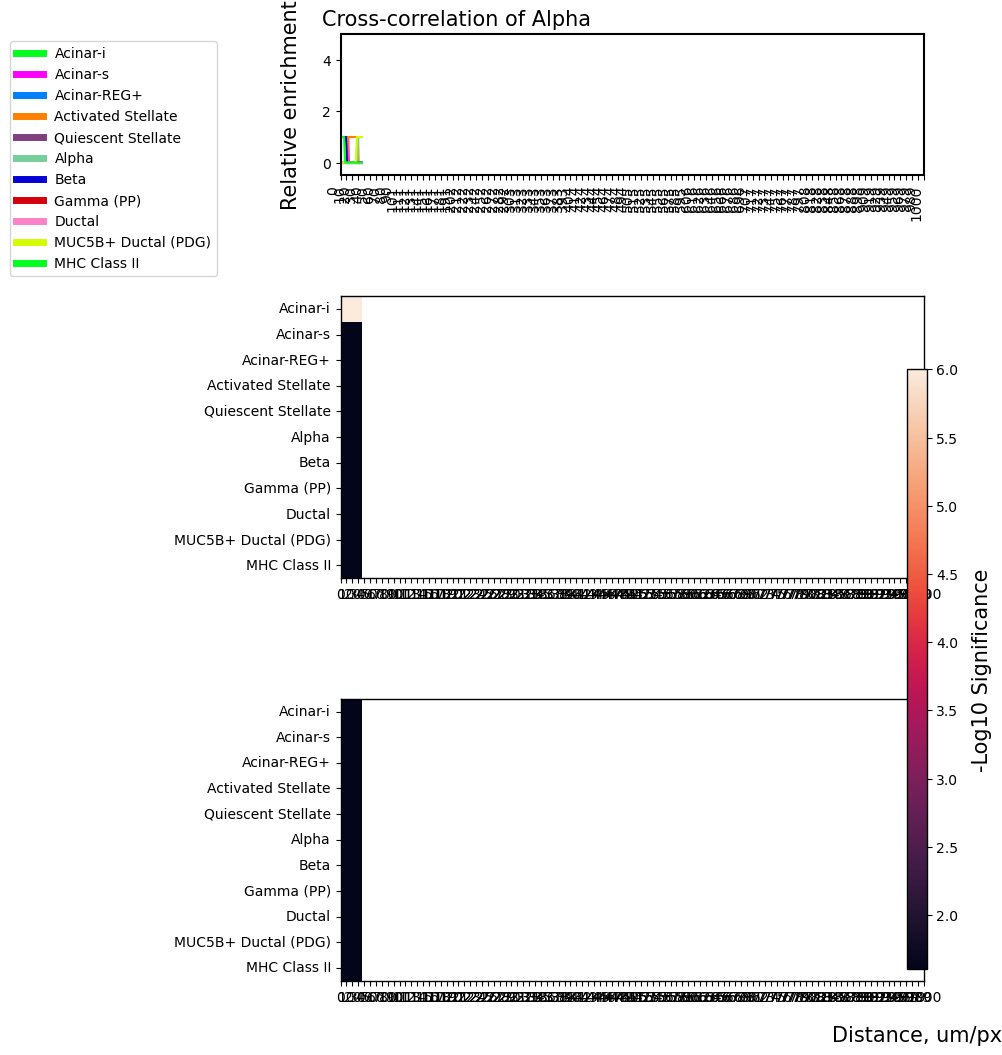

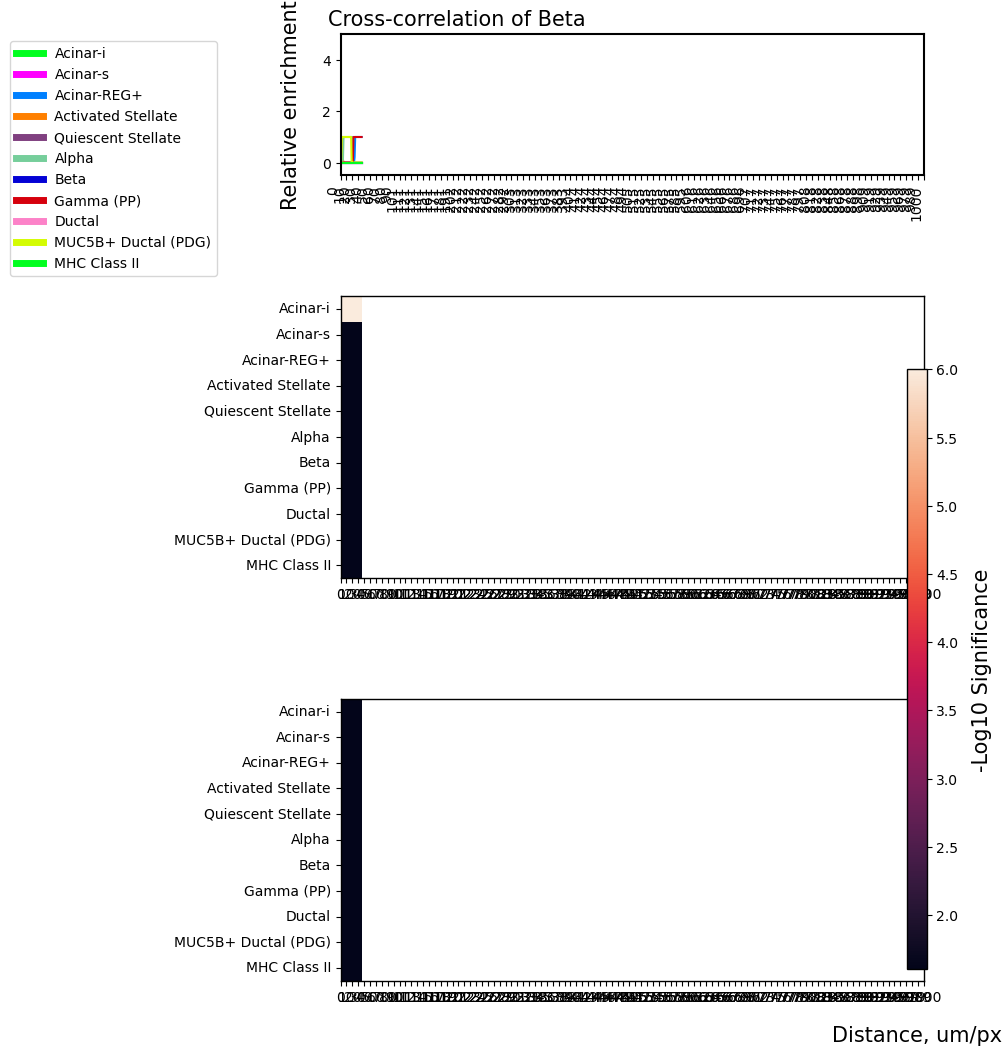

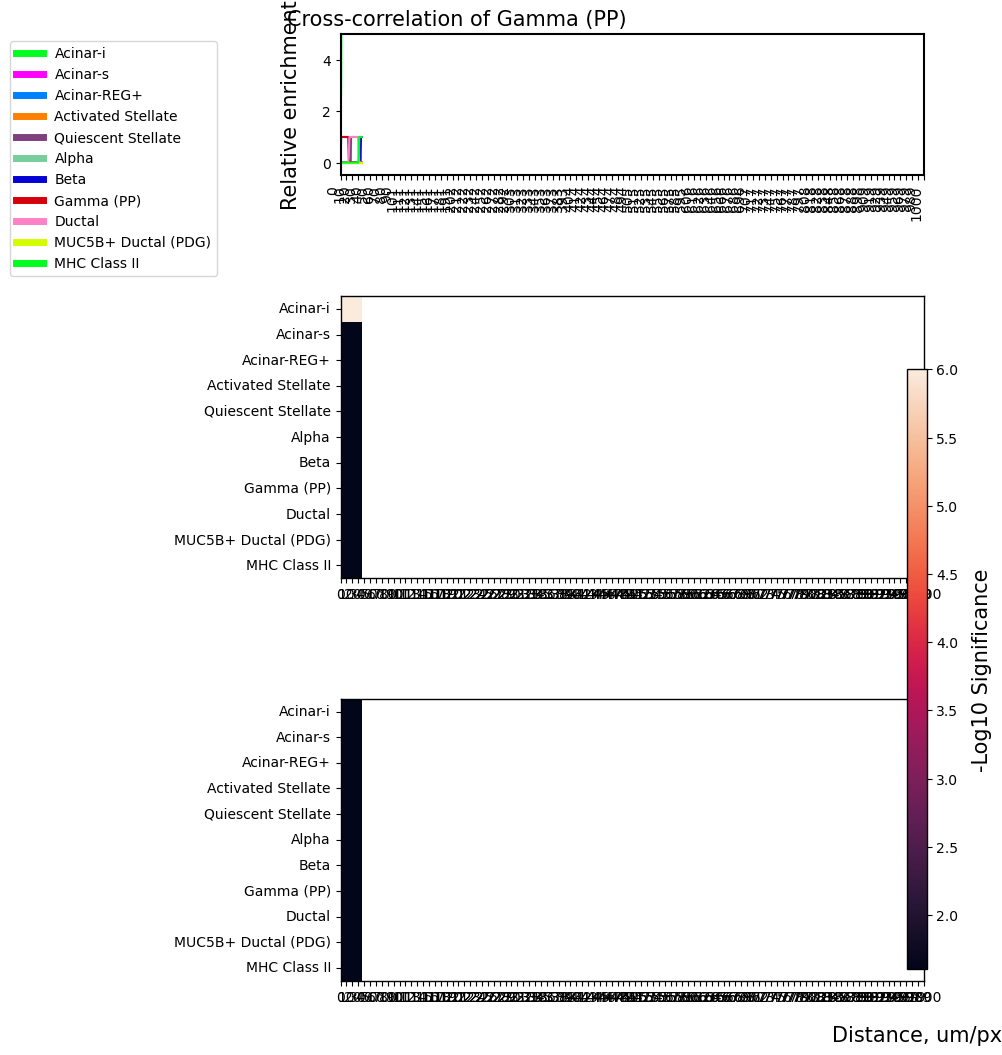

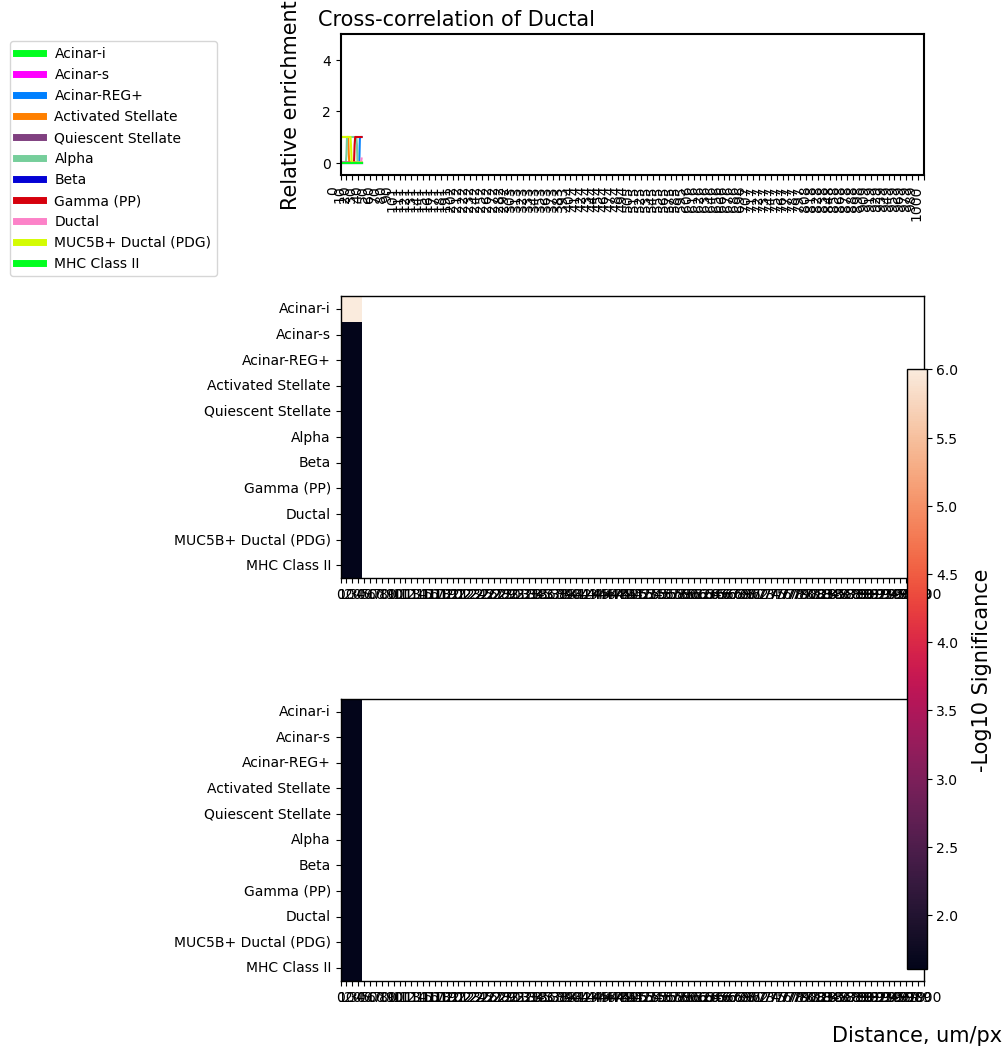

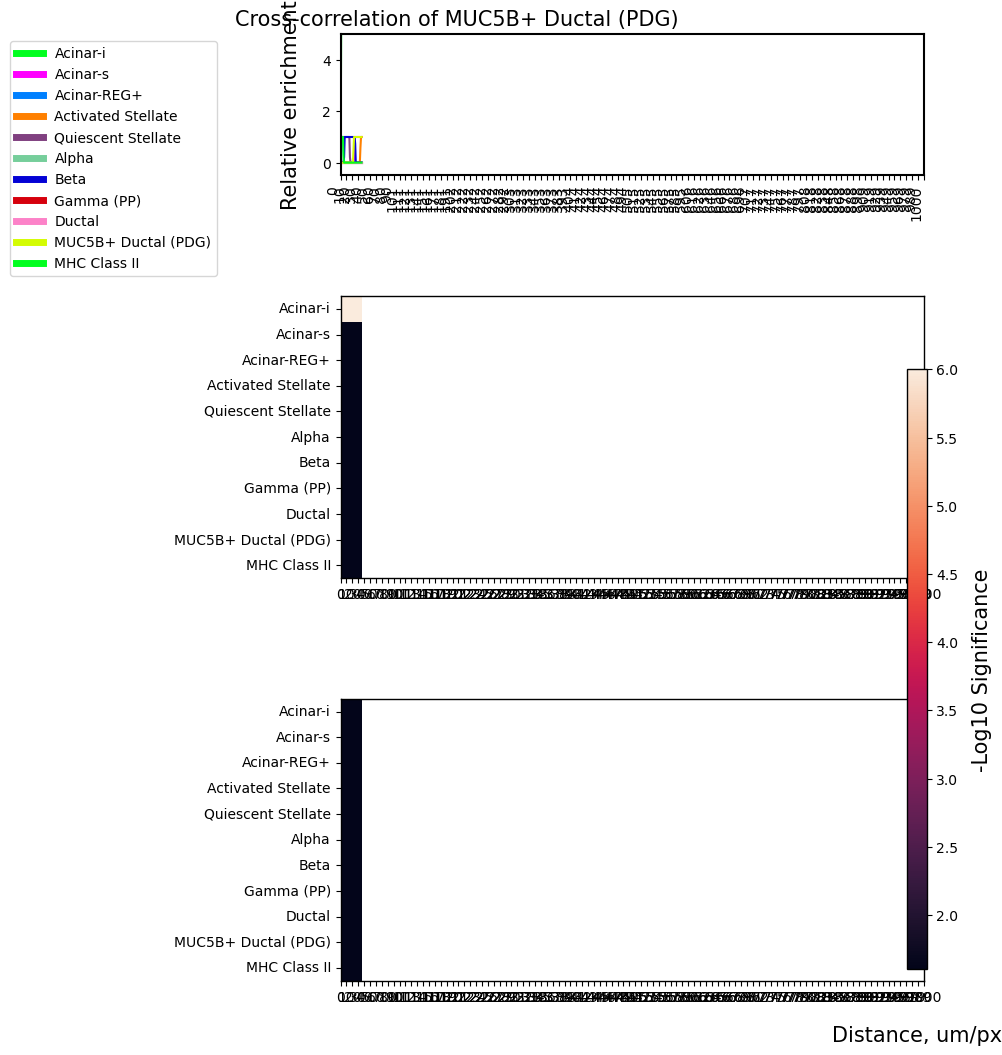

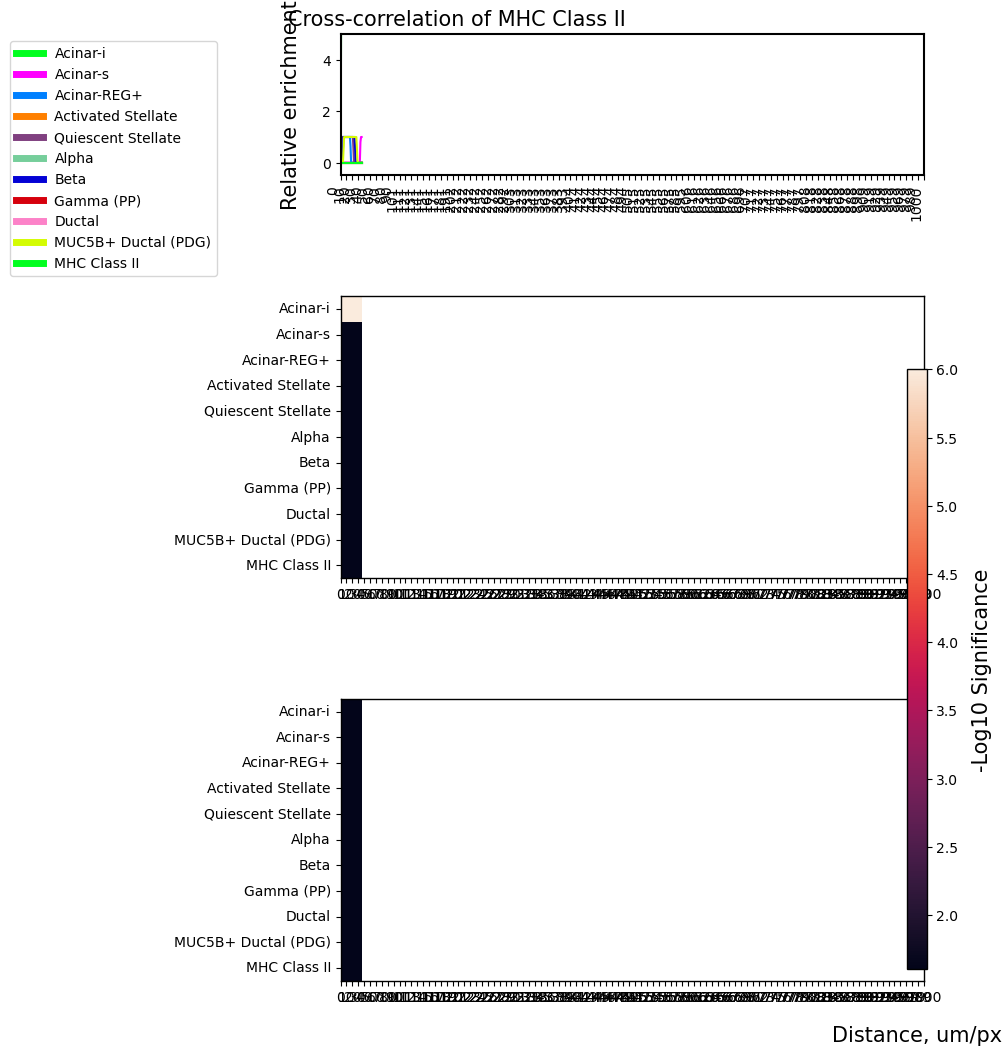

In [34]:
normalized_coocur=cooc_template_
metadata=metadata
seed_ = 13
threshold = 0.0005
significant_enrichment = stats_result
filename = "brain_1000",
scaling = 1

metadata["order_of_layers"] = list(range(len(metadata)))
    # metadata_reset = metadata.reset_index()
    # metadata_reset.rename(columns={'index': 'cell_type'}, inplace=True)
    # metadata_reset.set_index('order_of_layers', inplace=True)

all_cell_types = list(metadata.index)
cell_types_above_threshold = list(metadata.loc[metadata['pixel_proportions']>0.0005, 'order_of_layers'])
thresholded_cell_types = list(metadata.loc[metadata['pixel_proportions']>0.0005].index)


    # colors
    
random.seed(seed_)
    # number of colours to generate
N = len(cell_types_above_threshold)
    # generate N visually distinct colours
colors = distinctipy.get_colors(N)


    # # filenames
    # from datetime import datetime
    # current_datetime = datetime.now()
    # # Format the date and time
    # formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
    # # Create a PDF file
    # pdf_filename = filename + formatted_datetime + ".pdf"
    # pdf_pages = PdfPages(pdf_filename)



for figure in cell_types_above_threshold:

        # Initiating a figure
    # fig, axes = plt.subplots(3,1, figsize=(10,len(cell_types_above_threshold)//2), sharex=True)
    fig = plt.figure(figsize=(10, 10))  # Overall figure size
    # from matplotlib import gridspec
    gs = gridspec.GridSpec(3, 1, height_ratios=[1,2,2])

    pivot_cell_type = figure 

        # Sonar cross-correlation curves
    ax_curves = plt.subplot(gs[0])
    for target_cell_type in cell_types_above_threshold:

            # y_maximum = normalized_coocur[pivot_cell_type,:,10:].mean() + normalized_coocur[pivot_cell_type,:,10:].std()*2.5

        ax_curves.plot(normalized_coocur[pivot_cell_type,target_cell_type], label = all_cell_types[target_cell_type], color=colors[target_cell_type % len(colors)])
        ax_curves.legend(loc="upper right", bbox_to_anchor=(-0.2, 1))
        ax_curves.set_ylim(-0.5,5)
    ax_curves.set_ylabel('Relative enrichment', labelpad=15)


            
        # Define axes for each subplot
    heatmaps = [1, 2]

        # Define alternative types
    alternatives = significant_enrichment
    alt_name = ["less", "greater"]

    for heatmap_loc, alternative, a_name in zip(heatmaps, alternatives, alt_name):
        ax = plt.subplot(gs[heatmap_loc], sharex=ax_curves)
            # Significance heatmap of one-sided t-test
        sns.heatmap(-np.log10(alternative[pivot_cell_type, cell_types_above_threshold, :]), cmap="rocket", yticklabels=thresholded_cell_types, vmin=1.6, vmax=6, ax=ax, cbar=False)
            # Add a text annotation on the right side of the plot

        # Adjust the size of the other subplots vertically
        # For example, you can use the following code to adjust the size of ax2 and ax3:

        # ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width, 0.4])

        # ax.annotate(f"alternative={a_name}", xy=(0, 0), xytext=(620, 6), color="black",
        #                 rotation=-90, ha='right', va='center', fontsize=14)
            # Adjust the frame of the heatmap
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_visible(True)
            ax.spines[spine].set_linewidth(1)

        
        # Customize x-axis ticks
    xlox = np.linspace(0,1000,100)
    xtix = [str(int(i)) for i in xlox*scaling] # *3 is getting back from scaling the sample which was used for avoiding memory issues while calculating sonar curves
    plt.xticks(xlox,xtix)   
 # Rotate x-tick labels on the bottom subplot
    ax_curves.set_xticklabels(ax_curves.get_xticklabels(), rotation=90, ha='right')

    plt.tight_layout()

        # Create a color bar
    cbar_ax = fig.add_axes([0.95, 0.05, 0.02, 0.6])  # Adjust the values as needed
    cbar = plt.colorbar(ax.collections[0], cax=cbar_ax)
    cbar.set_label('-Log10 Significance', rotation=90, labelpad=10)
    cbar.outline.set_linewidth(1)

        # Adjust the linewidth of legend lines
    legend_lines = ax_curves.get_legend().get_lines()
    for line in legend_lines:
        line.set_linewidth(5.0)

    plt.xlabel('Distance, um/px', labelpad=40) # Add x-axis label to the entire figure
    plt.suptitle(f"Cross-correlation of {all_cell_types[figure]}", fontsize=15, y=1.01)

        # # Save the current figure to the PDF file
        # pdf_pages.savefig()

        # Close the current figure
    

    plt.show()

    plt.close()
    # # Close the PDF file
    # pdf_pages.close()

# plt.show()

In [30]:
metadata.columns

Index(['pixel_counts', 'pixel_proportions', 'order_of_layers'], dtype='object')

(-0.1, 5.0)

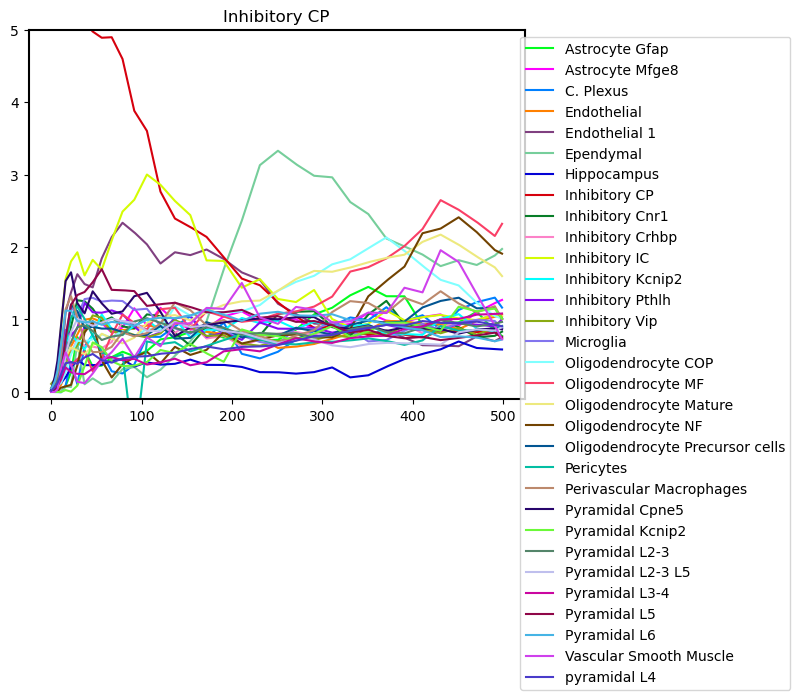

In [124]:
for target_cell_type in range(normalized_coocur.shape[1]):
    plt.plot(normalized_coocur[7, target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])

plt.legend(loc="upper right", bbox_to_anchor=(1.55, 1))
plt.title(f"{relevant_cluster_labels[7]}",  fontsize=12)
plt.ylim(-0.1,5)

In [129]:
plot_significant_enrichments(normalized_coocur=normalized_coocur,
                                    metadata=metadata,
                                    seed_ = 13,
                                    threshold = 0.0005,
                                    significant_enrichment = significant_enrichment,
                                    filename = "mouse_brain_2_",
                                    scaling = 1)

/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight 

# Analysis pipline

In [3]:
osmfish_ref = ['Astrocyte Gfap', 'Astrocyte Mfge8', 'C. Plexus', 'Endothelial', 
               'Endothelial 1', 'Ependymal', 'Hippocampus', 'Inhibitory CP', 
               'Inhibitory Cnr1', 'Inhibitory Crhbp', 'Inhibitory IC', 'Inhibitory Kcnip2', 
               'Inhibitory Pthlh', 'Inhibitory Vip', 'Microglia', 'Oligodendrocyte COP', 
               'Oligodendrocyte MF', 'Oligodendrocyte Mature', 'Oligodendrocyte NF', 
               'Oligodendrocyte Precursor cells', 'Pericytes', 'Perivascular Macrophages', 
               'Pyramidal Cpne5', 'Pyramidal Kcnip2', 'Pyramidal L2-3', 'Pyramidal L2-3 L5', 
               'Pyramidal L3-4', 'Pyramidal L5', 'Pyramidal L6', 'Vascular Smooth Muscle', 'pyramidal L4']

In [266]:
cooc_template_.shape

(32, 32, 500)

In [139]:
# # for rescaled, sample_name in zip(sample_list[1:], range(2,5)):

# def sig(t, k=1):
#     return ((1)/(1+(torch.exp(-t*k))))
# def smax(t,k=5):
#     return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))
# rad_ = 500
# lin = 1


# son = sonar.Sonar(max_radius=rad_,linear_radius_steps=lin, edge_correction=True, circumference_normalization=True)
# cooc_template_  = son.co_occurrence_from_tensor(tissue_matrix_brain[:-1],interpolate="linear", area_normalization = False) 


normalized_coocur, metadata = normalise_co_occurrence(tensor=cooc_template_, original_img = tissue_matrix_brain, cell_type_labels = osmfish_ref)


significant_enrichment = significance_test(normalized_coocur=normalized_coocur)


plot_significant_enrichments(normalized_coocur=normalized_coocur,
                                    metadata=metadata,
                                    seed_ = 13,
                                    threshold = 0.0005,
                                    significant_enrichment = significant_enrichment,
                                    filename = "brain_sample_1000um",
                                    scaling = 1)

/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/1403014847.py:90: UserWarning: Tight 

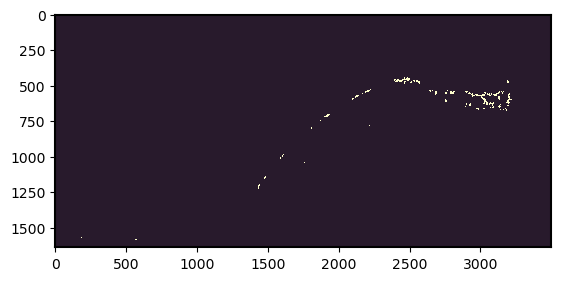

In [259]:
plt.imshow(tissue_matrix_brain[5])

# Correction to the cell counts in the sample

In [63]:
# calculation of the tissue area of each cell-type
def total_pixel_counts(original_img = rescaled, cell_type_labels = relevant_cluster_labels):

    tissue_pixels = []
    for i in range(1,len(cell_type_labels)+1):
        pix_agreg = np.sum(rescaled[i]) # rescaled[i+1] because under 0 here is a background
        tissue_pixels.append(pix_agreg)

    return list(tissue_pixels)

pixel_counts = total_pixel_counts(rescaled)

In [65]:
# calculation of ratio of cells that are present in the sample

cell_type_proportions = []

total_n = sum(pixel_counts)

for cell_type_counts in pixel_counts:
    ratio = (cell_type_counts)/total_n
    ratio = round(ratio,5)
    cell_type_proportions.append(ratio)

print(cell_type_proportions)


[0.08869, 0.80838, 0.00477, 0.00438, 0.00511, 0.00255, 0.00914, 0.00063, 0.00029, 0.06517, 0.00945, 0.00118, 0.00026, 0.0, 0.0]


In [68]:
pixel_counts_dict_persantage = dict(zip(relevant_cluster_labels, cell_type_proportions))

In [145]:
pixel_counts_dict = dict(zip(relevant_cluster_labels, pixel_counts))
pixel_counts_dict

{'Acinar-i': 76427.0,
 'Acinar-s': 696597.0,
 'Acinar-REG+': 4112.0,
 'Activated Stellate': 3774.0,
 'Quiescent Stellate': 4405.0,
 'Alpha': 2195.0,
 'Beta': 7873.0,
 'Gamma (PP)': 547.0,
 'Delta': 249.0,
 'Ductal': 56161.0,
 'MUC5B+ Ductal (PDG)': 8143.0,
 'MHC Class II': 1017.0,
 'Schwan': 222.0,
 'B cell': 0.0,
 'T cell': 0.0}

In [69]:
pixel_counts_dict_persantage

{'Acinar-i': 0.08869,
 'Acinar-s': 0.80838,
 'Acinar-REG+': 0.00477,
 'Activated Stellate': 0.00438,
 'Quiescent Stellate': 0.00511,
 'Alpha': 0.00255,
 'Beta': 0.00914,
 'Gamma (PP)': 0.00063,
 'Delta': 0.00029,
 'Ductal': 0.06517,
 'MUC5B+ Ductal (PDG)': 0.00945,
 'MHC Class II': 0.00118,
 'Schwan': 0.00026,
 'B cell': 0.0,
 'T cell': 0.0}

# Filtering out zeros

In [154]:
empty_cell_type_map = [index for index, value in enumerate(pixel_counts_dict_persantage.values()) if value == 0]

print("Indices of values below 0.05:", empty_cell_type_map) 

Indices of values below 0.05: [13, 14]


In [161]:
cooc_template_filtered_from_zeros =np.delete(cooc_template_, empty_cell_type_map, axis=0)
cooc_template_filtered_from_zeros =np.delete(cooc_template_filtered_from_zeros, empty_cell_type_map, axis=1)

In [162]:
cooc_template_filtered_from_zeros.shape

(13, 13, 500)

# Normalization

In [165]:

# Normalisation to the number of pixels of cell-types in the tissue

def normalize_co_occurrence_matrix(tensor = cooc_template_filtered_from_zeros, cell_counts = pixel_counts):
    n, _, m = tensor.shape
    normalized_coocur = np.zeros_like(tensor)
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_coocur[i, j, k] = tensor[i, j, k] / (cell_counts[j]*cell_type_proportions[i])
    
    return normalized_coocur


normalized_coocur = normalize_co_occurrence_matrix(cooc_template_filtered_from_zeros)

In [166]:
normalized_coocur.shape

(13, 13, 500)

# Filtering out low abundant cells from the report

In [167]:
indices_above_threshold = [index for index, value in enumerate(pixel_counts_dict_persantage.values()) if value > 0.0005]

print("Indices of values below 0.05:", indices_above_threshold) # those are being reported on plots

Indices of values below 0.05: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]


In [48]:
# # preserved colors
# colors = [(0.04539659990856526, 0.9950834146451918, 0.1499488663005254),
#  (1.0, 0.0, 1.0),
#  (0.0, 0.5, 1.0),
#  (1.0, 0.5, 0.0),
#  (0.5, 0.25, 0.5),
#  (0.3806287930848872, 0.9587938095125506, 0.7309407555134216),
#  (0.765350367801373, 0.9841022759439689, 0.05801173998599107),
#  (0.9214116218515722, 0.5101069244842528, 0.8965838031677331),
#  (0.20848553008387116, 0.012218971422101932, 0.9672051864008775),
#  (1.0, 0.0, 0.0),
#  (0.0, 0.5, 0.0),
#  (0.0, 0.5, 0.5),
#  (0.3379250810420038, 0.0247771750361111, 0.6305114722526198),
#  ]

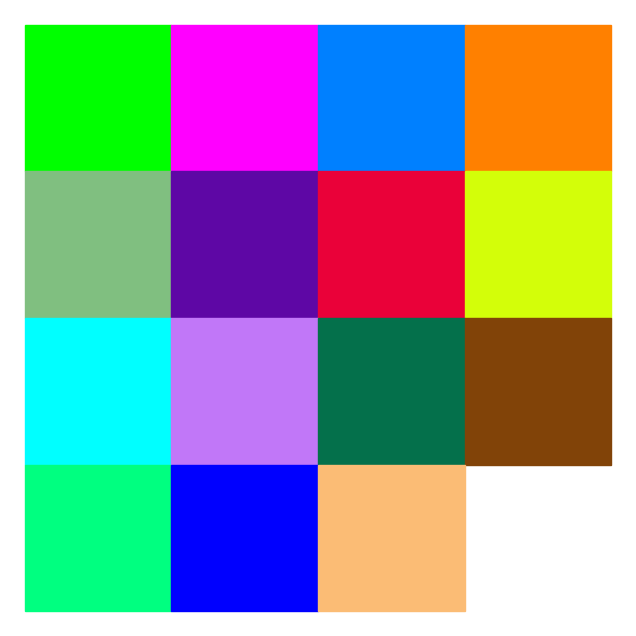

In [72]:
from distinctipy import distinctipy
import random

random.seed(42)

# number of colours to generate
# N = len(indices_above_threshold)
N = 15

# generate N visually distinct colours
colors = distinctipy.get_colors(N)

# display the colours
distinctipy.color_swatch(colors)




In [64]:
    
for target_cell_type in indices_above_threshold:

    plt.plot(normalized_coocur[5,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
    plt.title("cross-corellation of Alpha cells, interpolate='linear")
    plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1))

plt.ylim(-0,5)
plt.show()

NameError: name 'indices_above_threshold' is not defined

In [116]:
# def compute_bbox_anchor(n_axes, x_ratio=34, y_ratio=30):
#     # Scale the x and y ratios based on the number of axes
#     scaled_x = x_ratio / n_axes
#     scaled_y = y_ratio / n_axes
#     return (scaled_x, scaled_y)

/tmp/ipykernel_1522821/1668378835.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


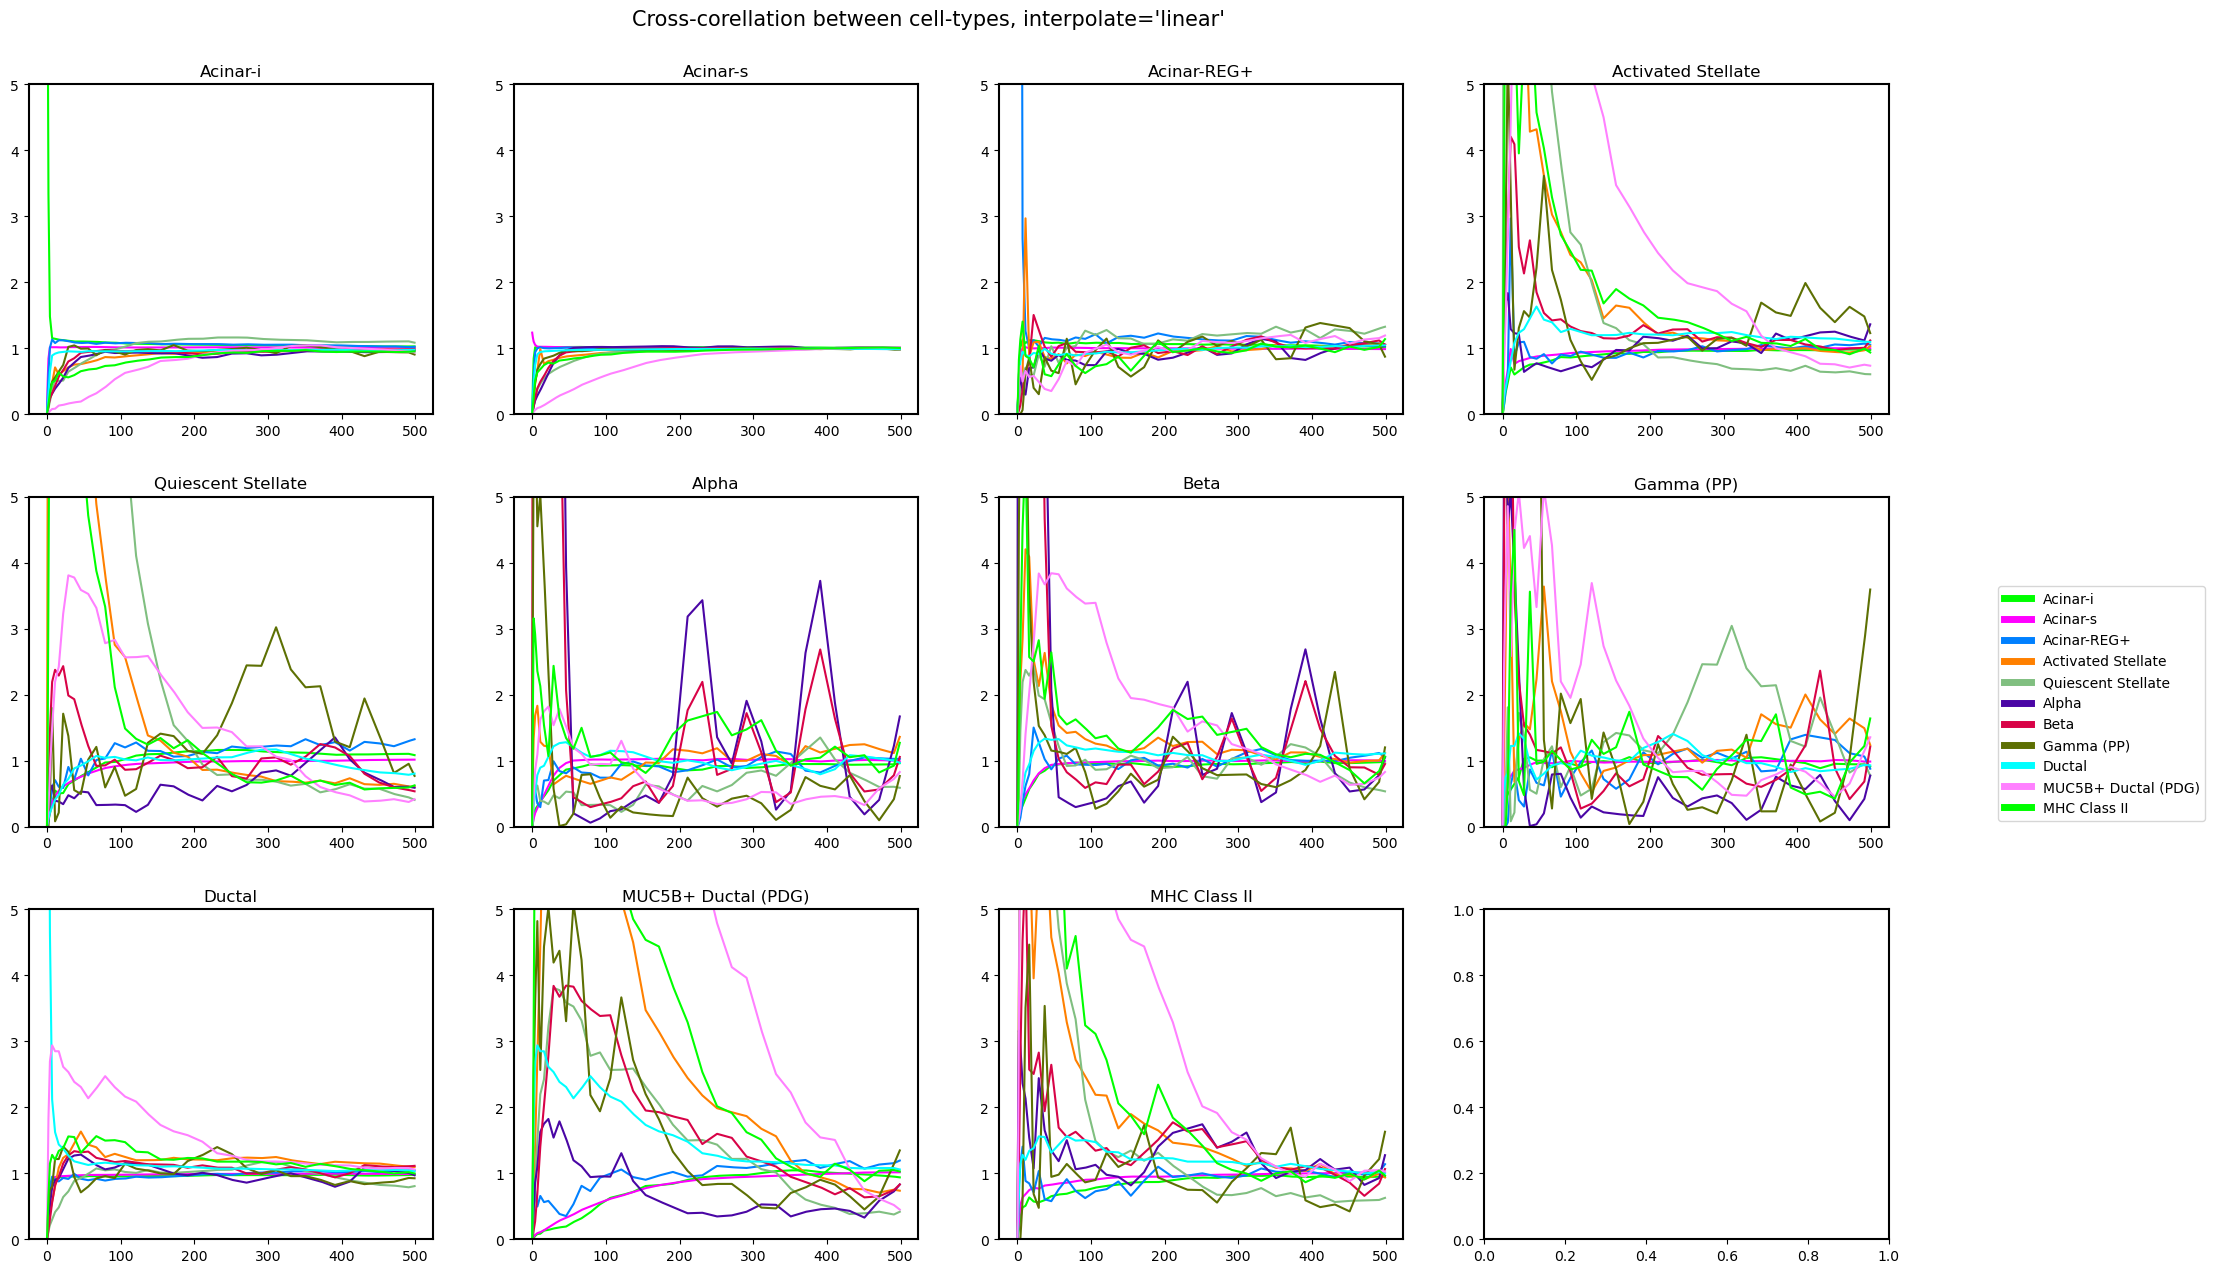

In [169]:
total_plots = len(indices_above_threshold)  # Example total number of plots
n_cols = 4       # Fixed number of columns

# Calculate the number of rows needed
n_rows = math.ceil(total_plots / n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 15), gridspec_kw={'hspace': 0.25})

for ax_order, pivot_cell_type in enumerate(indices_above_threshold):  
    row = ax_order // n_cols
    col = ax_order % n_cols
    ax = axes[row, col]

    y_maximum = normalized_coocur[pivot_cell_type,:,10:].mean() + normalized_coocur[pivot_cell_type,:,10:].std()*2

    for target_cell_type in indices_above_threshold:

        ax.plot(normalized_coocur[pivot_cell_type,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
        ax.set_title(f"{relevant_cluster_labels[pivot_cell_type]}",  fontsize=12)
        ax.set_ylim(0, 5)
    
ax.legend(loc="upper right", bbox_to_anchor=(3,2))

# Adjust the linewidth of legend lines
legend_lines = ax.get_legend().get_lines()
for line in legend_lines:
    line.set_linewidth(5.0)


plt.suptitle("Cross-corellation between cell-types, interpolate='linear'", fontsize=15, y=0.93)
plt.tight_layout()
plt.show()

## SIgnificance test

In [170]:
# alternative='less'

significance_test_less = np.zeros((normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2]))


for pivot_cell_type in range(normalized_coocur.shape[0]):
    for target_cell_type in range(normalized_coocur.shape[1]):
        for distance in range(normalized_coocur.shape[2]):

            value_to_test = normalized_coocur[pivot_cell_type, target_cell_type, distance]
            t_statistic, p_value = stats.ttest_1samp(normalized_coocur[pivot_cell_type,:,distance], value_to_test, alternative='less')
            significance_test_less[pivot_cell_type, target_cell_type, distance] = p_value


In [171]:
significance_test_flatten_less = significance_test_less.flatten()
corrected_p_values_less = smm.multipletests(significance_test_flatten_less, method='fdr_bh')[1]

In [172]:
corrected_p_values3D_less = corrected_p_values_less.reshape(normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2])

In [173]:
# alternative='greater'

significance_test_great = np.zeros((normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2]))


for pivot_cell_type in range(normalized_coocur.shape[0]):
    for target_cell_type in range(normalized_coocur.shape[1]):
        for distance in range(normalized_coocur.shape[2]):

            value_to_test = normalized_coocur[pivot_cell_type, target_cell_type, distance]
            t_statistic, p_value = stats.ttest_1samp(normalized_coocur[pivot_cell_type,:,distance], value_to_test, alternative='greater')
            significance_test_great[pivot_cell_type, target_cell_type, distance] = p_value

In [174]:
significance_test_flatten_great = significance_test_great.flatten()
corrected_p_values_great = smm.multipletests(significance_test_flatten_great, method='fdr_bh')[1]

In [175]:
corrected_p_values3D_great = corrected_p_values_great.reshape(normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2])

Text(0.5, 1.0, 'Alpha cells, Significance test')

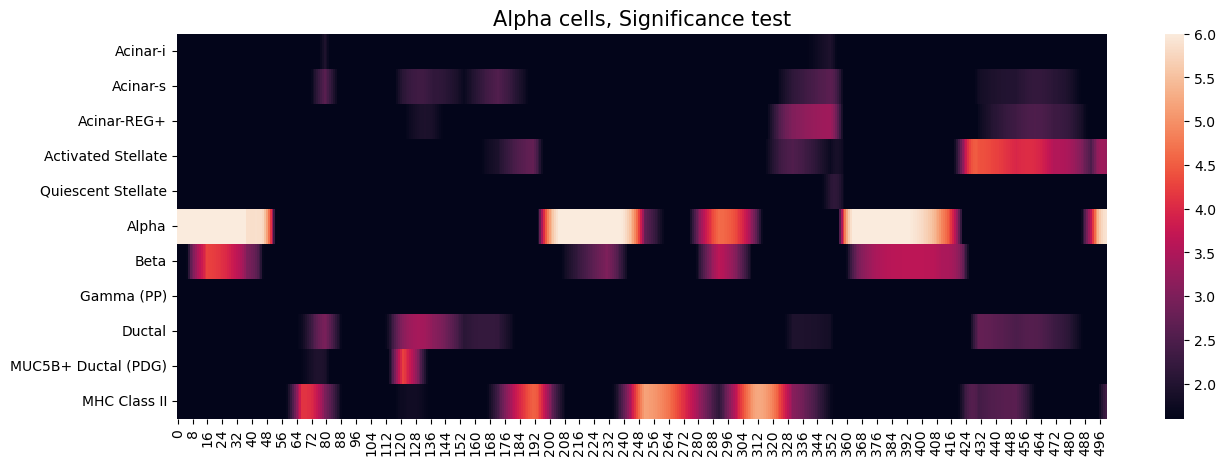

In [179]:
# single cell type

plt.figure(figsize = (15,5))
sns.heatmap(-np.log10(significance_test_less[5,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6)
plt.title("Alpha cells, Significance test")


In [ ]:
total_plots = len(indices_above_threshold)  # Example total number of plots
n_cols = 4       # Fixed number of columns

# Calculate the number of rows needed
n_rows = math.ceil(total_plots / n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 15), gridspec_kw={'hspace': 0.25})

for ax_order, pivot_cell_type in enumerate(indices_above_threshold):  
    row = ax_order // n_cols
    col = ax_order % n_cols
    ax = axes[row, col]

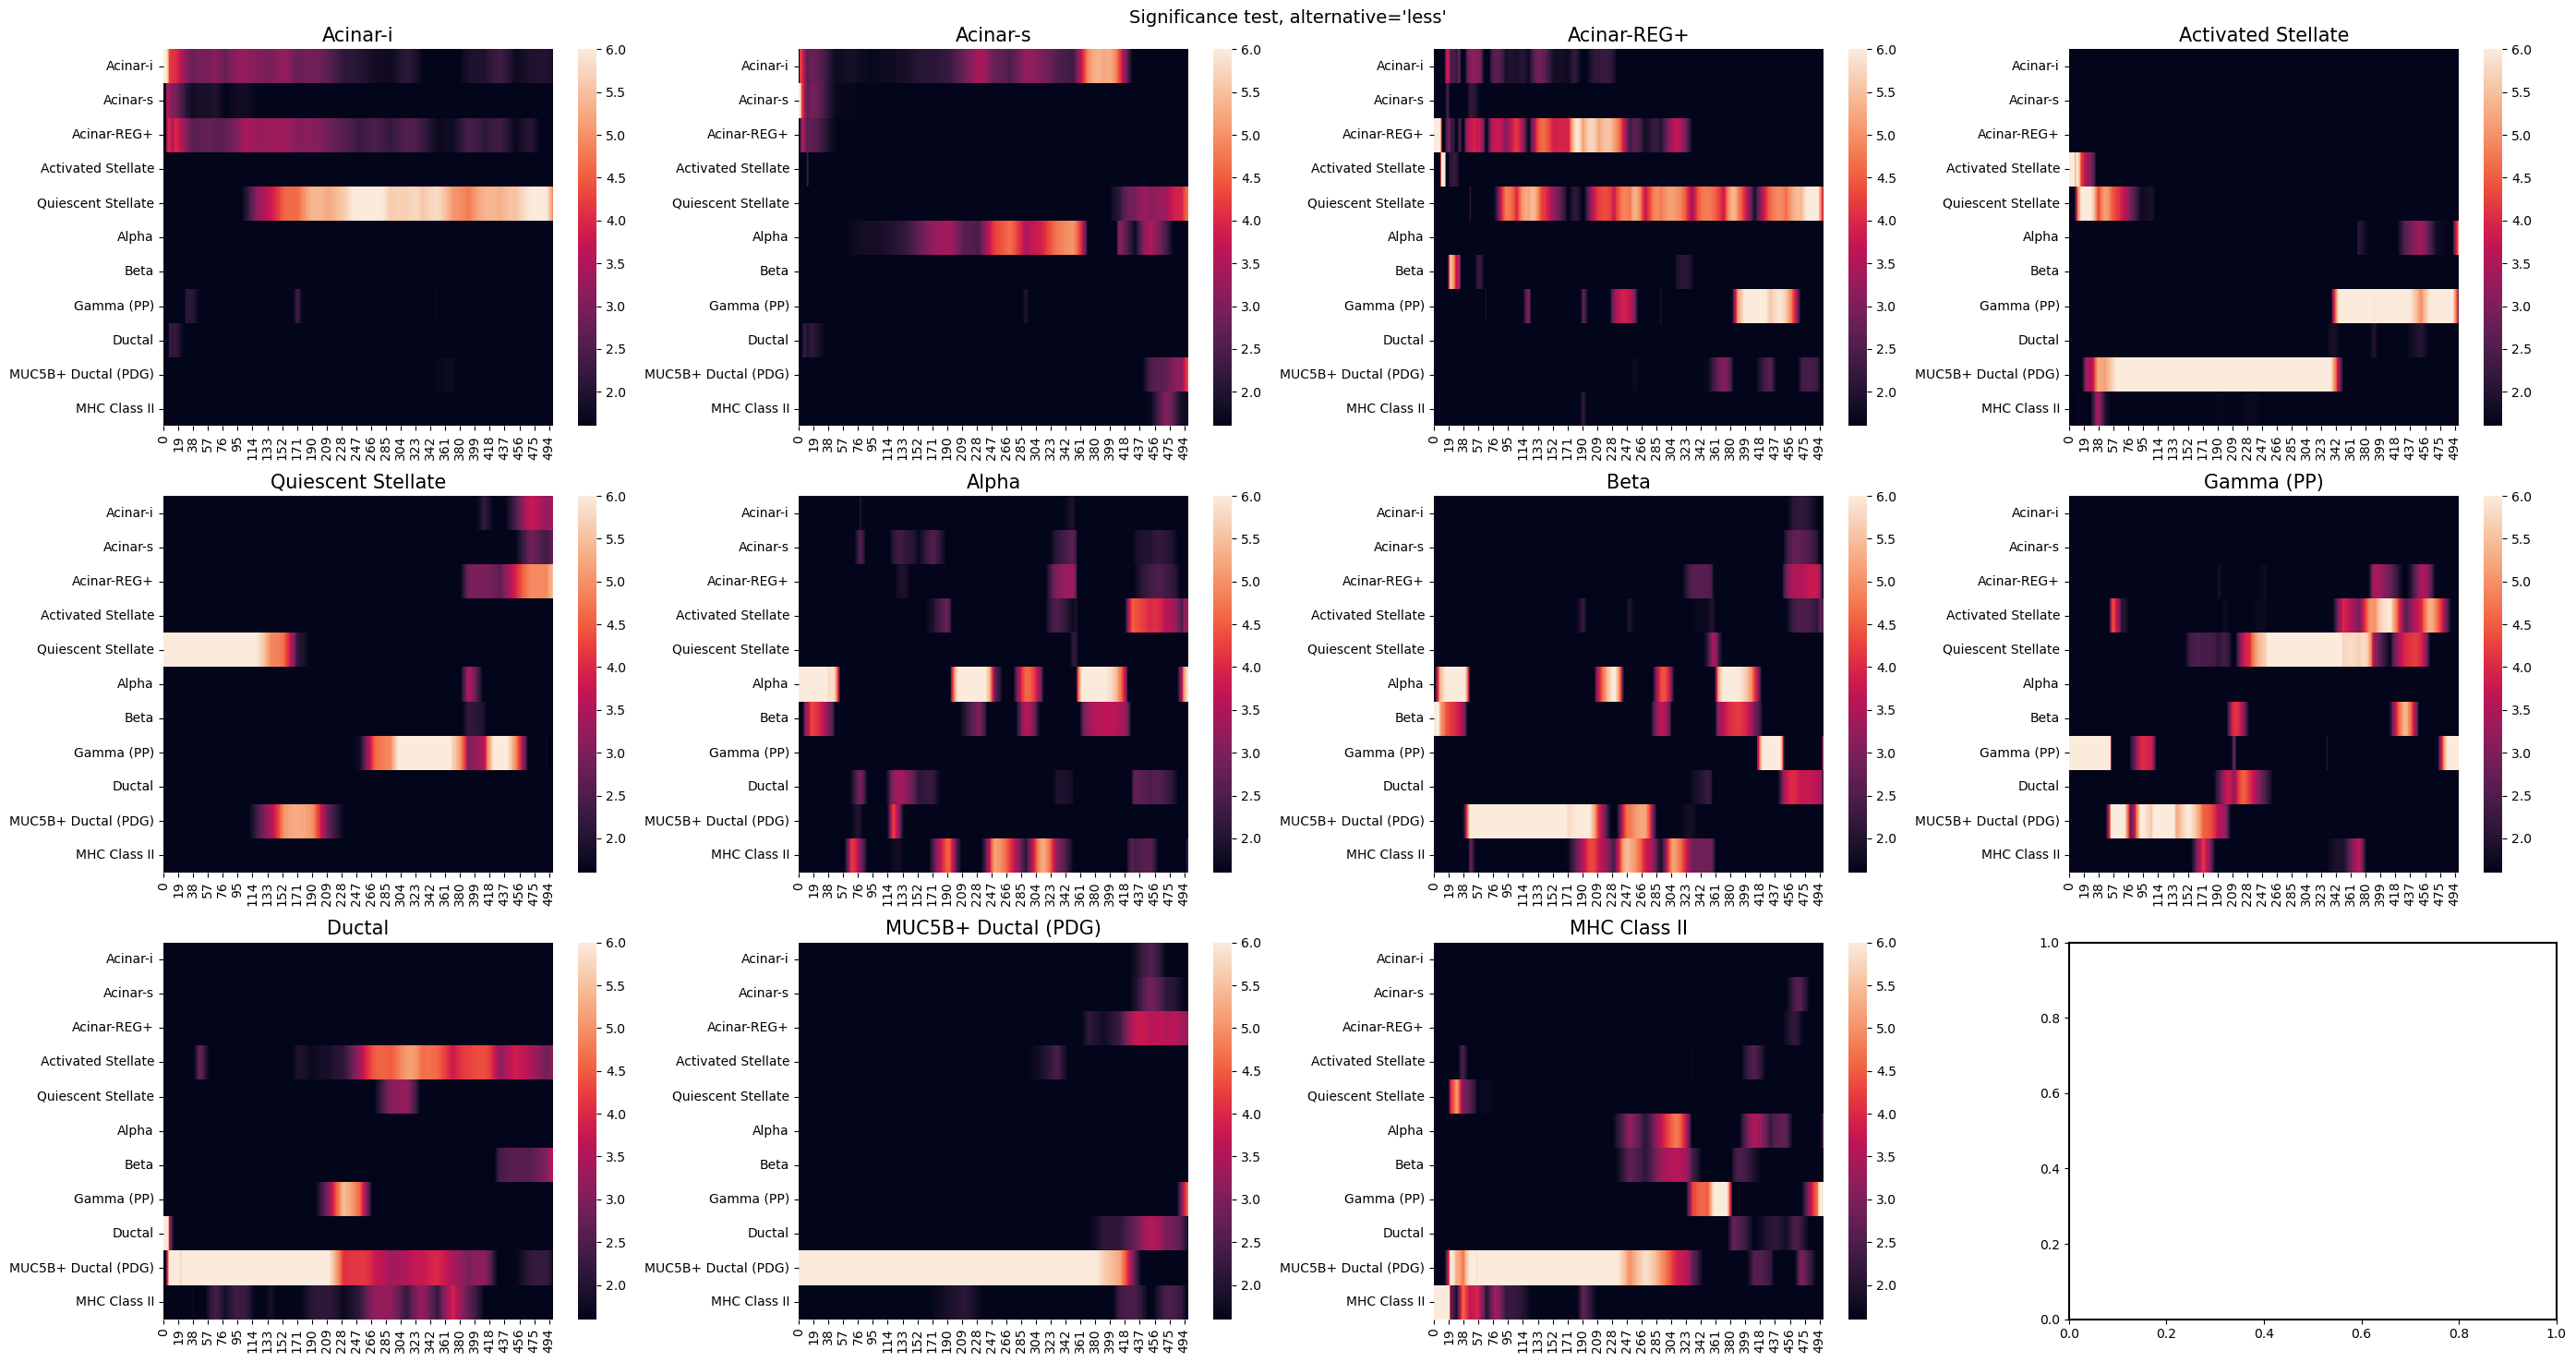

In [183]:
# alternative='less'

total_plots = len(indices_above_threshold)  # Example total number of plots
n_cols = 4       # Fixed number of columns

# Calculate the number of rows needed
n_rows = math.ceil(total_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (28,15))

for ax_order, pivot_cell_type in enumerate(indices_above_threshold):  
    row = ax_order // n_cols
    col = ax_order % n_cols
    ax = axes[row, col]

    sns.heatmap(-np.log10(significance_test_less[pivot_cell_type,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6, ax=ax)
    ax.set_title(f"{relevant_cluster_labels[pivot_cell_type]}")

plt.suptitle("Significance test, alternative='less'", fontsize = 14)
plt.tight_layout()
plt.show()

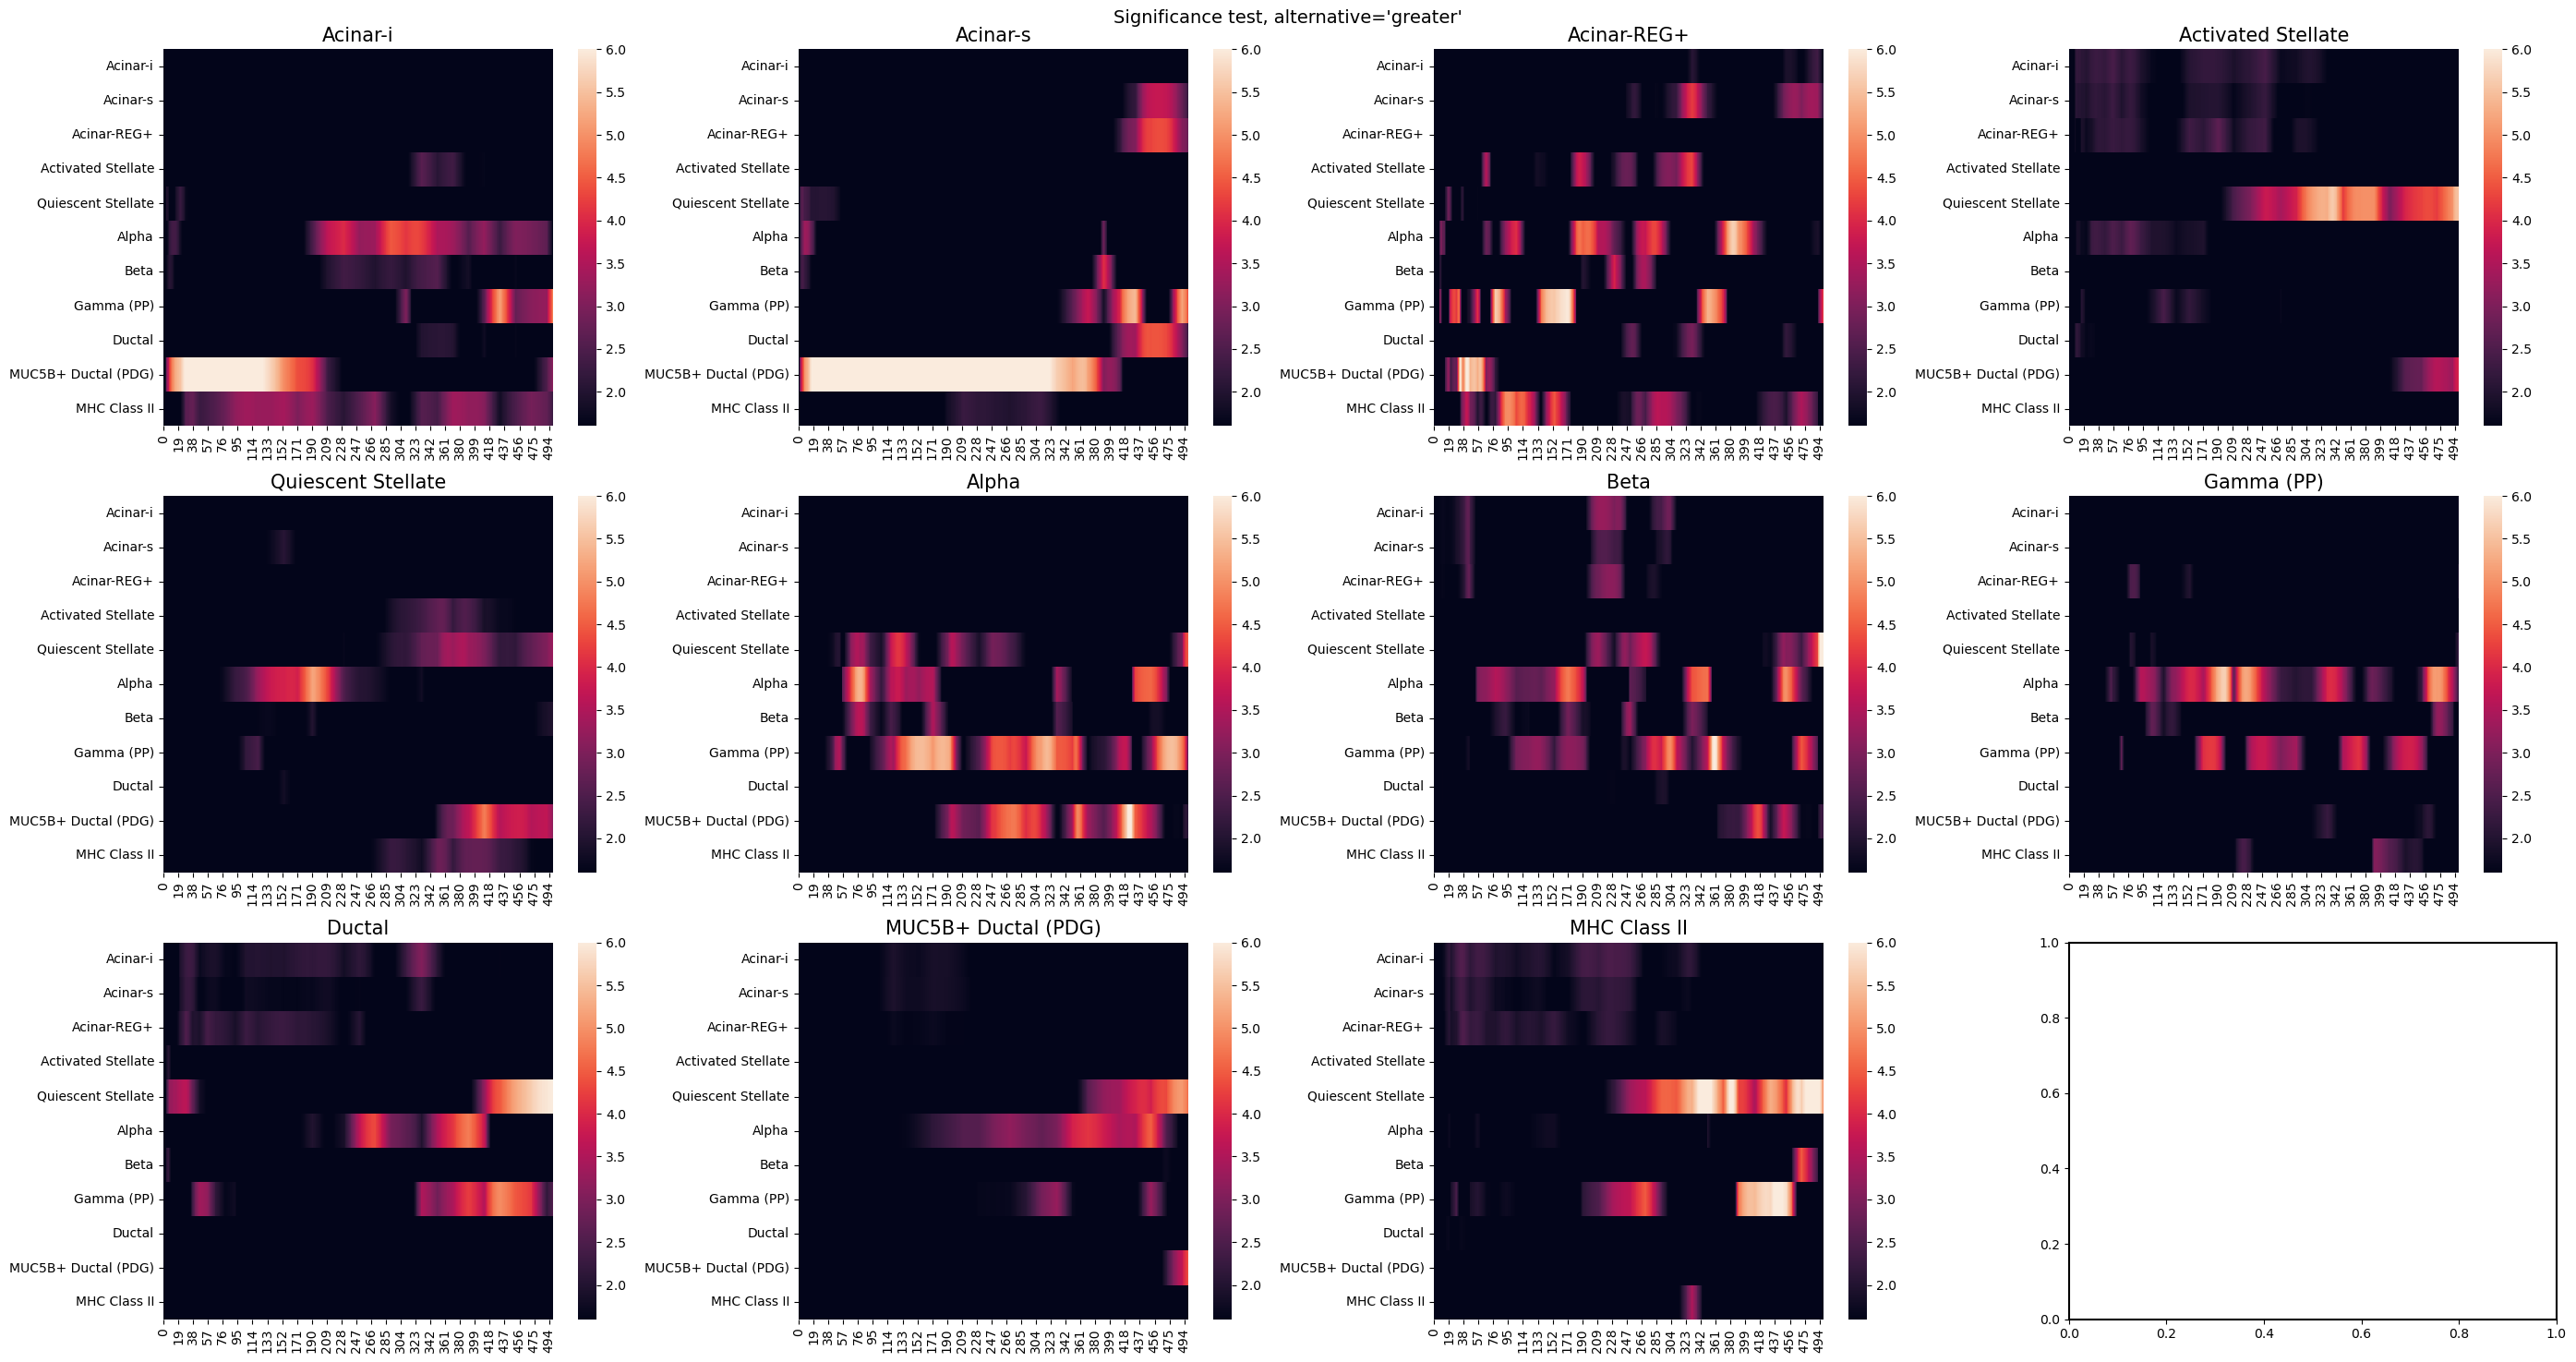

In [184]:
# alternative='greater'

total_plots = len(indices_above_threshold)  # Example total number of plots
n_cols = 4       # Fixed number of columns

# Calculate the number of rows needed
n_rows = math.ceil(total_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (28,15))

for ax_order, pivot_cell_type in enumerate(indices_above_threshold):  
    row = ax_order // n_cols
    col = ax_order % n_cols
    ax = axes[row, col]

    sns.heatmap(-np.log10(significance_test_great[pivot_cell_type,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6, ax=ax)
    ax.set_title(f"{relevant_cluster_labels[pivot_cell_type]}")

plt.suptitle("Significance test, alternative='greater'", fontsize = 14)
plt.tight_layout()
plt.show()

## Different types of plots together for comparison

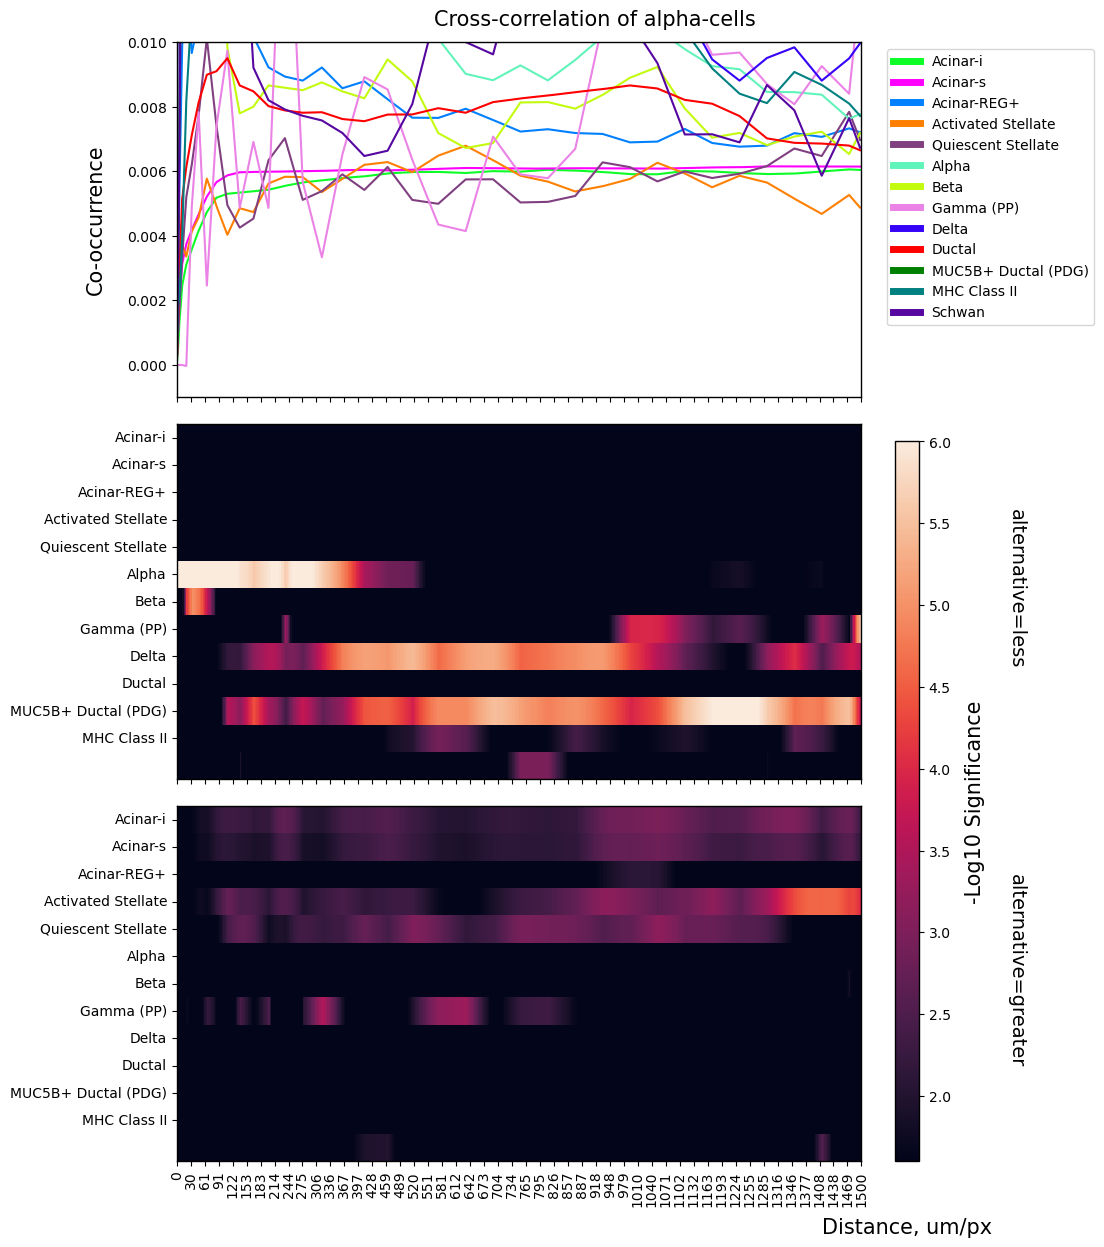

In [318]:
fig, axes = plt.subplots(3,1, figsize = (12,12), sharex=True)
pivot_cell_type = 5


ax_curves = axes[0]
for target_cell_type in range(normalized_coocur.shape[1]):
    ax_curves.plot(normalized_coocur[5,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
    ax_curves.legend(loc="upper right", bbox_to_anchor=(1.35, 1))
    ax_curves.set_ylim(-0.001, 0.01)
ax_curves.set_ylabel('Co-occurrence', labelpad=15)


ax_less = axes[1]
sns.heatmap(-np.log10(significance_test_less[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax_less, cbar=False)
# Adjust the frame of the heatmap
ax_less.spines['top'].set_visible(True)
ax_less.spines['right'].set_visible(True)
ax_less.spines['bottom'].set_visible(True)
ax_less.spines['left'].set_visible(True)


ax_great = axes[2]
sns.heatmap(-np.log10(significance_test_great[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax_great, cbar=False)


# Adjust the frame of the heatmap
ax_great.spines['top'].set_visible(True)
ax_great.spines['right'].set_visible(True)
ax_great.spines['bottom'].set_visible(True)
ax_great.spines['left'].set_visible(True)


# Adjust the frame of all plots
for ax in [ax_curves, ax_less, ax_great]:
    ax.spines['top'].set_linewidth(1) 
    ax.spines['right'].set_linewidth(1) 
    ax.spines['bottom'].set_linewidth(1)  # Adjust linewidth as needed
    ax.spines['left'].set_linewidth(1)

# Customize x-axis ticks
xlox = np.linspace(0,500,50)
xtix = [str(int(i)) for i in xlox*3] # *3 is getting back from scaling the sample which was used for avoiding memory issues while calculating sonar curves
plt.xticks(xlox,xtix)    


plt.tight_layout()

# Create a color bar
cbar_ax = fig.add_axes([0.75, 0.05, 0.02, 0.6])  # Adjust the values as needed
cbar = plt.colorbar(ax_less.collections[0], cax=cbar_ax)
cbar.set_label('-Log10 Significance', rotation=90, labelpad=10)
cbar.outline.set_linewidth(1)

# Adjust the linewidth of legend lines
legend_lines = ax_curves.get_legend().get_lines()
for line in legend_lines:
    line.set_linewidth(5.0)


# Add a text annotation on the right side of an alternative=less plot
ax_less.annotate("alternative=less", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)

# Add a text annotation on the right side of an alternative=greater plot
ax_great.annotate("alternative=greater", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)


plt.xlabel('Distance, um/px', labelpad=40) # Add x-axis label to the entire figure
plt.suptitle("Cross-correlation of alpha-cells", fontsize=15, y=1.01)
plt.show()

In [185]:
from matplotlib.backends.backend_pdf import PdfPages

In [186]:
from datetime import datetime

current_datetime = datetime.now()

# Format the date and time
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")

print(formatted_datetime)

2023_08_24_14_54_38


In [188]:
pdf_filename = "pancreas_sample1_" + formatted_datetime + ".pdf"
pdf_filename

'pancreas_sample1_2023_08_24_14_54_38.pdf'

In [190]:
# Create a PDF file
pdf_filename = "pancreas_sample1_" + formatted_datetime + ".pdf"
pdf_pages = PdfPages(pdf_filename)

for figure in indices_above_threshold:

    # Initiating a figure
    fig, axes = plt.subplots(3,1, figsize = (12,12), sharex=True)

    pivot_cell_type = figure 

    # Sonar cross-correlation curves
    ax_curves = axes[0]
    for target_cell_type in indices_above_threshold:

        # y_maximum = normalized_coocur[pivot_cell_type,:,10:].mean() + normalized_coocur[pivot_cell_type,:,10:].std()*2.5

        ax_curves.plot(normalized_coocur[pivot_cell_type,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
        ax_curves.legend(loc="upper right", bbox_to_anchor=(1.35, 1))
        ax_curves.set_ylim(0,5)
    ax_curves.set_ylabel('Relative enrichment', labelpad=15)
        
    # Significance heatmap of one-sided t-test, alternative=less
    ax_less = axes[1]
    sns.heatmap(-np.log10(significance_test_less[pivot_cell_type,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6, ax=ax_less, cbar=False)
    # ax_less.set_title("alternative=less")
    # Add a text annotation on the right side of an alternative=less plot
    ax_less.annotate("alternative=less", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)
    # Adjust the frame of the heatmap
    ax_less.spines['top'].set_visible(True)
    ax_less.spines['right'].set_visible(True)
    ax_less.spines['bottom'].set_visible(True)
    ax_less.spines['left'].set_visible(True)

    # Significance heatmap of one-sided t-test, alternative=greater
    ax_great = axes[2]
    sns.heatmap(-np.log10(significance_test_great[pivot_cell_type,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6, ax=ax_great, cbar=False)
    # ax_great.set_title("alternative=greater")
    # Add a text annotation on the right side of an alternative=greater plot
    ax_great.annotate("alternative=greater", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)
    # Adjust the frame of the heatmap
    ax_great.spines['top'].set_visible(True)
    ax_great.spines['right'].set_visible(True)
    ax_great.spines['bottom'].set_visible(True)
    ax_great.spines['left'].set_visible(True)

    for ax in [ax_curves, ax_less, ax_great]:
        ax.spines['top'].set_linewidth(1) 
        ax.spines['right'].set_linewidth(1) 
        ax.spines['bottom'].set_linewidth(1)  # Adjust linewidth as needed
        ax.spines['left'].set_linewidth(1)

    
    # Customize x-axis ticks
    xlox = np.linspace(0,500,50)
    xtix = [str(int(i)) for i in xlox*3] # *3 is getting back from scaling the sample which was used for avoiding memory issues while calculating sonar curves
    plt.xticks(xlox,xtix)   

    plt.tight_layout()

    # Create a color bar
    cbar_ax = fig.add_axes([0.75, 0.05, 0.02, 0.6])  # Adjust the values as needed
    cbar = plt.colorbar(ax_less.collections[0], cax=cbar_ax)
    cbar.set_label('-Log10 Significance', rotation=90, labelpad=10)
    cbar.outline.set_linewidth(1)

    # Adjust the linewidth of legend lines
    legend_lines = ax_curves.get_legend().get_lines()
    for line in legend_lines:
        line.set_linewidth(5.0)

    plt.xlabel('Distance, um/px', labelpad=40) # Add x-axis label to the entire figure
    plt.suptitle(f"Cross-correlation of {relevant_cluster_labels[figure]}", fontsize=15, y=1.01)

    # Save the current figure to the PDF file
    pdf_pages.savefig()

    # Close the current figure
    plt.close()

# Close the PDF file
pdf_pages.close()

plt.show()